# Analysis of S&P 500 Companies
Neo Zhao & Timothy Yang

## Introduction

Wealth is a highly sought after status that many struggle to attain but few achieve. It comes in many forms and has many more uses. Some may choose to save their life earnings to slowly aquire wealth, but some braver may choose to risk their earnings in the stock market. 


Among these there are those who try to invest for the long-term profit and those who invest for the short-term gain. The goal of the long-term investors is oftentimes to grow their wealth at a rate exceeding inflation or at the very least to outperform their next best investment (,such as the interest rate banks provide). The invest in companies that they believe will continue to grow, because they believe in the profitability of the companies' business model.


However, the more daring believe in 'beating the market', which is to invest in such a way to outperform the S&P500 index. They believe that at any given point in the market some stocks are overrated, so should be sold, and some are underrated should be bought. In doing so, they will outmaneuver their adversaries, other traders, and profit. Many try, but most fail. More information about 'beating the market' can be found here https://www.investopedia.com/ask/answers/12/beating-the-market.asp#:~:text=The%20phrase%20%22beating%20the%20market,beat%20it%2C%20but%20few%20succeed


The S&P500 (Standard & Poor's 500) represents approximately the top 500 largest publicly traded companies in the U.S.. It is often regarded as the best gauge to how well major buisinesses are performing for some time period. To learn more about the S&P500 visit this site https://www.investopedia.com/terms/s/sp500.asp


In the past humans would analyze the trend in the market to make their decisions. However, with the rapid improvement of computer processing speed and machine learning algorithms, trading is largely done by and between computers. Computers will analyze the trends of the market, and try to outperform their adversaries, other computers; the one with the more accuracte algorithm or better luck will profit.


Today, we will walk you through a simple tutorial of a rudimentary algorithm for modeling the stock market, with the goal of 'beating the market'. In the model we train, we will be predicting whether the stocks of a company will go up or down from day to day. Based on this prediction we can determine whether or not to buy or sell stocks. 


For example if we sold a stock when we expect a stock to lose value, we can sell stocks today and buy them back tomorrow. If we are correct in our prediction then we would have earned the difference in value times the number of stocks we sold. If we think a stock will gain value, we can buy stocks today and sell them back tomorrow. Again we would have earned the difference in value times the number of stocks bought.


However, some constraints we face is that we do not have access to the most recent data, we are unable to model how our machine's decision influence the market, and we have limited processing power. The goal of this tutorial is not to build a model that will truly outperform the market, but to guide the audience on how to develop such a model.

In [2]:
# imports
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import datetime as dt
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import math
from sklearn.model_selection import cross_validate

## Data Collection

### Web Scraping Wikipedia

In this project, we'll mainly focus on the S&P 100, because we have limited computational resources. That said, there was this really nice table from wikipedia about the S&P 500 (Source:  https://en.wikipedia.org/wiki/List_of_S%26P_500_companies), which contains information about the company and its industry classification. We scrape this wikipedia's table below:



In [4]:
r = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
root = bs(r.content, "html")
sp500 = pd.read_html(root.find('table').prettify())[0]
sp500.head()

Symbol             Security  ...      CIK      Founded
0    MMM           3M Company  ...    66740         1902
1    ABT  Abbott Laboratories  ...     1800         1888
2   ABBV          AbbVie Inc.  ...  1551152  2013 (1888)
3   ABMD          ABIOMED Inc  ...   815094         1981
4    ACN        Accenture plc  ...  1467373         1989

[5 rows x 9 columns]

To isolate just the S&P 100, we need some way to identify them, so here we also scrape another table from wikipedia which lists the S&P 100 (Source: https://en.wikipedia.org/wiki/S%26P_100): 

In [5]:
r = requests.get('https://en.wikipedia.org/wiki/S%26P_100')
root = bs(r.content, "html")
sp100 = pd.read_html(root.find_all('table')[2].prettify())[0]
sp100.head()

Symbol                 Name
0   AAPL           Apple Inc.
1   ABBV          AbbVie Inc.
2    ABT  Abbott Laboratories
3    ACN            Accenture
4   ADBE           Adobe Inc.

### Pulling from Huge Stock Market Dataset

For this section, all of our stock data comes from a dataset from Kaggle: 

https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

This data set is massive, containing information on over a 8500 funds and stocks, each stored in their own files. I've (Neo) downloaded the dataset and put it on a publically available repository to facilitate its use in this project.

We'll only pull the data which corresponds to the S&P 500 to match with the data we pulled from the S&P 500 table since it would be a waste of memory to load in all 8500+ files into dataframes. The raw github repo links are mostly similar, with the individual files named after the stock name. So, below we use common url heads and tails to pull datasets for just the S&P 500 companies found on the list in wikipedia.

In [6]:
url_common_head = 'https://raw.githubusercontent.com/neo-zhao/CMSC320_Final_Tutorial_Huge_Stock_Market_Dataset/main/Stocks/'
url_common_tail = '.us.txt'

sp500stocks = pd.DataFrame()
unavailable_stocks = []

for i in range(sp500['Symbol'].size):
  try:
    data = pd.read_csv(url_common_head + sp500['Symbol'][i].lower() + url_common_tail)
    data['Symbol'] = [sp500['Symbol'][i]]*data.shape[0]
    sp500stocks = pd.concat([sp500stocks, data])
  except:
    print(sp500['Symbol'][i].lower() + url_common_tail + ' does not exist in the Huge Stock Market Dataset.')
    unavailable_stocks += [sp500['Symbol'][i]]

print(str(len(unavailable_stocks)) + ' companies\' data could not be found in the Huge Stock Market Dataset')
sp500stocks.head()

amcr.us.txt does not exist in the Huge Stock Market Dataset.
aptv.us.txt does not exist in the Huge Stock Market Dataset.
bkr.us.txt does not exist in the Huge Stock Market Dataset.
brk.b.us.txt does not exist in the Huge Stock Market Dataset.
bkng.us.txt does not exist in the Huge Stock Market Dataset.
bf.b.us.txt does not exist in the Huge Stock Market Dataset.
carr.us.txt does not exist in the Huge Stock Market Dataset.
cbre.us.txt does not exist in the Huge Stock Market Dataset.
ctva.us.txt does not exist in the Huge Stock Market Dataset.
dow.us.txt does not exist in the Huge Stock Market Dataset.
evrg.us.txt does not exist in the Huge Stock Market Dataset.
gl.us.txt does not exist in the Huge Stock Market Dataset.
peak.us.txt does not exist in the Huge Stock Market Dataset.
hwm.us.txt does not exist in the Huge Stock Market Dataset.
iqv.us.txt does not exist in the Huge Stock Market Dataset.
j.us.txt does not exist in the Huge Stock Market Dataset.
lhx.us.txt does not exist in the

Date    Open    High     Low   Close  Volume  OpenInt Symbol
0  1970-01-02  2.1664  2.1749  2.1664  2.1664   84754        0    MMM
1  1970-01-05  2.1664  2.1833  2.1664  2.1749  525466        0    MMM
2  1970-01-06  2.1749  2.2002  2.1749  2.2002  207172        0    MMM
3  1970-01-07  2.2002  2.2172  2.1917  2.2086  193991        0    MMM
4  1970-01-08  2.2086  2.2512  2.2086  2.2427  357846        0    MMM

Now, we have everything we need and just need to do a lot of clean up; cutting out irrelevant data and refining what is left. So, it's on to **Data Processing** from here.

## Data Processing

In this section, we make use of Pandas and NumPy to manipulate our dataframes, which are Pandas based objects. Below, I link to the docs for these libraries, so you can explore more of their functionality there:

Pandas: https://pandas.pydata.org/docs/index.html

NumPy: https://numpy.org/doc/stable/index.html

### Cleaning sp500 (Wikipedia) Dataframe

As seen when compiling data from the Huge Stock Market Dataset, some of the companies don't have corresponding data in our dataset.

In [7]:
# print inital size
print(sp500.shape[0])

# remove the unavailable stocks
sp500_1 = sp500[~sp500['Symbol'].isin(unavailable_stocks)]

# print new size
print(sp500_1.shape[0])

505
477


Now that that's done, lets late a look at the features of this dataframe:

In [8]:
sp500_1.head()

Symbol             Security  ...      CIK      Founded
0    MMM           3M Company  ...    66740         1902
1    ABT  Abbott Laboratories  ...     1800         1888
2   ABBV          AbbVie Inc.  ...  1551152  2013 (1888)
3   ABMD          ABIOMED Inc  ...   815094         1981
4    ACN        Accenture plc  ...  1467373         1989

[5 rows x 9 columns]

Most of this looks fine as is, but there are several improvements that can be made:
*   SEC filings is just an entire column filled with 'report'. On the Wikipedia webpage, these were hyperlinks to SEC filing records for the company, but in our table, it's useless and thus can be cut from the dataframe. 
*   Similarly, Central Index Key (CIK) is just a number given to an individual, company, or foreign government by the United States Securities and Exchange Commission. It is completely random and should have no use in our model and thus can also be cut from the dataframe.
*   The data in the 'Date first added' column is a time, so it would be best represented by a UTC DateTime object instead of a string.
*   The 'Founded' column seems to have a few strange entries and should be cleaned so that all data is in the same format. Also, since it is also time data, it would be best represented by a UTC DateTime object instead of a string.

With these tasks listed one, let's go through them one by one.



#### Cutting out **SEC filings** and **CIK**

In [9]:
sp500_2 = sp500_1.drop(columns=['SEC filings'])
sp500_3 = sp500_2.drop(columns=['CIK'])
sp500_3.head()

Symbol             Security  ... Date first added      Founded
0    MMM           3M Company  ...       1976-08-09         1902
1    ABT  Abbott Laboratories  ...       1964-03-31         1888
2   ABBV          AbbVie Inc.  ...       2012-12-31  2013 (1888)
3   ABMD          ABIOMED Inc  ...       2018-05-31         1981
4    ACN        Accenture plc  ...       2011-07-06         1989

[5 rows x 7 columns]

#### Adjusting **Date first added**

Apparently, there are some inconsistent formatting in this section as well. Some strings had extra parenthesised dates tailing the initial date, and some are just NaN. Since we already have an abundence of data, we will just ignore these data points and drop them.

In [10]:
datetime_date_first_added = []
dropped_companies = []

for r in sp500_3.iterrows():
  try:
    datetime_date_first_added += [datetime.strptime(r[1]['Date first added'], '%Y-%m-%d')]
  except: 
    datetime_date_first_added += [np.NaN]
    dropped_companies += [r[1]['Symbol']]

sp500_4 = sp500_3.copy()
sp500_4['Date first added'] = datetime_date_first_added
sp500_4.head()

Symbol             Security  ... Date first added      Founded
0    MMM           3M Company  ...       1976-08-09         1902
1    ABT  Abbott Laboratories  ...       1964-03-31         1888
2   ABBV          AbbVie Inc.  ...       2012-12-31  2013 (1888)
3   ABMD          ABIOMED Inc  ...       2018-05-31         1981
4    ACN        Accenture plc  ...       2011-07-06         1989

[5 rows x 7 columns]

And now to remove the  rows with NaN values:

In [11]:
# print initial size
print(sp500_4.shape[0])

# remove dropped companies
sp500_5 = sp500_4[~sp500_4['Symbol'].isin(dropped_companies)]

# print new size
print(sp500_5.shape[0])

477
424


Now, just to make sure the type of the object in the 'Date first added' column is a datetime, we print out the dtypes of the dataframe:

In [12]:
sp500_5.dtypes

Symbol                           object
Security                         object
GICS  Sector                     object
GICS Sub-Industry                object
Headquarters Location            object
Date first added         datetime64[ns]
Founded                          object
dtype: object

#### Cleaning **Founded**

Similar to how we handled the 'Date first added' column, we will just drop any row which has inconsistent formatting and convert the others into datetime objects. So, first we build the new 'Founded' column:

In [13]:
founded = []

for r in sp500_5.iterrows():
  try:
    founded += [datetime.strptime(r[1]['Founded'], '%Y')]
  except: 
    founded += [np.NaN]
    dropped_companies += [r[1]['Symbol']]

sp500_6 = sp500_5.copy()
sp500_6['Founded'] = founded
sp500_6.head()

Symbol             Security  ... Date first added    Founded
0    MMM           3M Company  ...       1976-08-09 1902-01-01
1    ABT  Abbott Laboratories  ...       1964-03-31 1888-01-01
2   ABBV          AbbVie Inc.  ...       2012-12-31        NaT
3   ABMD          ABIOMED Inc  ...       2018-05-31 1981-01-01
4    ACN        Accenture plc  ...       2011-07-06 1989-01-01

[5 rows x 7 columns]

And now to remove the  rows with NaN values:

In [14]:
# print initial size
print(sp500_6.shape[0])

# remove dropped companies
sp500_7 = sp500_6[~sp500_6['Symbol'].isin(dropped_companies)]

# print new size
print(sp500_7.shape[0])

424
392


Just like before, lets take a look at the dtypes to make sure the 'Founded' column has been successfully converted into datetime objects:

In [15]:
sp500_7.dtypes

Symbol                           object
Security                         object
GICS  Sector                     object
GICS Sub-Industry                object
Headquarters Location            object
Date first added         datetime64[ns]
Founded                  datetime64[ns]
dtype: object

### Joining Wikipedia Dataframes

First, remove unavailable_stocks from sp100

In [16]:
# print inital size
print(sp100.shape[0])

# remove the unavailable stocks
sp100_1 = sp100[~sp100['Symbol'].isin(unavailable_stocks)]

# print new size
print(sp100_1.shape[0])

101
98


Now, remove all data points from sp500 and sp500stock which do not share a symbol with sp100:

In [17]:
# print inital size
print(sp500_7.shape[0])

# remove the unavailable stocks
sp500_7_1 = sp500_7[sp500_7['Symbol'].isin(sp100_1['Symbol'])]

# print new size
print(sp500_7_1.shape[0])

392
79


In [18]:
# print initial size
print(sp500stocks.shape[0])

# remove dropped companies
sp500stocks_0_1 = sp500stocks[sp500stocks['Symbol'].isin(sp100_1['Symbol'])]

# print new size
print(sp500stocks_0_1.shape[0])

2594230
739062


With this, only data for companies from the S&P 100 are left in all of our dataframes. 

### Cleaning sp500stocks (Kaggle) Dataframe

Before anything else, there's a list of dropped companies which need to be removed from this dataframe:

In [19]:
# print initial size
print(sp500stocks_0_1.shape[0]) # remove _0_1 if 500

# remove dropped companies
sp500stocks_1 = sp500stocks_0_1[~sp500stocks_0_1['Symbol'].isin(dropped_companies)] # remove _0_1 if 500

# print new size
print(sp500stocks_1.shape[0])

739062
620097


Just to be sure, lets compare the unique values of the 'Symbol' column for sp500 and sp500stocks. Since they should have the same unique values, they should be equal after sorting. Since we're working with numpy arrays, a comparison of the sorted arrays should result in an array filled with Trues. Let's verify this:

In [20]:
sp500su = sp500stocks_1['Symbol'].unique()
sp500su.sort()

sp500u = sp500_7_1['Symbol'].unique() # remove _1 if 500
sp500u.sort()

sp500u == sp500su

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

Now, let's take a look at the features of this dataframe and come up with a checklist for cleaning:

In [21]:
sp500stocks_1.head()

Date    Open    High     Low   Close  Volume  OpenInt Symbol
0  1970-01-02  2.1664  2.1749  2.1664  2.1664   84754        0    MMM
1  1970-01-05  2.1664  2.1833  2.1664  2.1749  525466        0    MMM
2  1970-01-06  2.1749  2.2002  2.1749  2.2002  207172        0    MMM
3  1970-01-07  2.2002  2.2172  2.1917  2.2086  193991        0    MMM
4  1970-01-08  2.2086  2.2512  2.2086  2.2427  357846        0    MMM

There are several types of issues to address:

*   Dropping useless data
*   Data type conversion
*   Find overlapping timeframe



#### Dropping useless data

The 'OpenInt' column doesn't look too useful based off the the head that we displayed earlier. Let's take a more complete look at it to see what unique values it has:

In [22]:
sp500stocks_1['OpenInt'].unique()

array([0])

It appears that the 'OpenInt' column is just a column full of zeroes. Since it has no variation at all between any of the stocks, it is completely useless as a feature for distinguishing between them. So, we can drop it:

In [23]:
sp500stocks_2 = sp500stocks_1.drop(columns=['OpenInt'])
sp500stocks_2.head()

Date    Open    High     Low   Close  Volume Symbol
0  1970-01-02  2.1664  2.1749  2.1664  2.1664   84754    MMM
1  1970-01-05  2.1664  2.1833  2.1664  2.1749  525466    MMM
2  1970-01-06  2.1749  2.2002  2.1749  2.2002  207172    MMM
3  1970-01-07  2.2002  2.2172  2.1917  2.2086  193991    MMM
4  1970-01-08  2.2086  2.2512  2.2086  2.2427  357846    MMM

#### Data type conversion

Ideally:
  *   Date should be a datetime type
  *   Open, High, Low, and Close should be floats
  *   Volume should be an integer
  *   Symbol should be a string

Before anything else, let's see what the current types are for this dataframe:


In [24]:
sp500stocks_2.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Symbol     object
dtype: object

So, it looks like all we need to do is to convert the objects in the 'Date' column into datetime objects.

In case anything has an inconsistent format, we will keep a dataframe of inconsistent rows and deal with it as needed. Unlike in the previous dataset where we could simply drop it, we also have to worry about the date here since we don't want any breaks timewise in the data for any given company.

In [25]:
date = []
inconsistent_rows = pd.DataFrame(columns=sp500stocks_2.columns)

# 
for r in sp500stocks_2.iterrows():
  try:
    date += [datetime.strptime(r[1]['Date'], '%Y-%m-%d')]
  except: 
    date += [np.NaN]
    inconsistent_rows.append(r)


sp500stocks_3 = sp500stocks_2.copy()
sp500stocks_3['Date'] = date
sp500stocks_3.head()

Date    Open    High     Low   Close  Volume Symbol
0 1970-01-02  2.1664  2.1749  2.1664  2.1664   84754    MMM
1 1970-01-05  2.1664  2.1833  2.1664  2.1749  525466    MMM
2 1970-01-06  2.1749  2.2002  2.1749  2.2002  207172    MMM
3 1970-01-07  2.2002  2.2172  2.1917  2.2086  193991    MMM
4 1970-01-08  2.2086  2.2512  2.2086  2.2427  357846    MMM

Just to be sure we've converted everything successfully, let's examine the new types for the dataframe:

In [26]:
sp500stocks_3.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Symbol            object
dtype: object

Next, let's take a look at the inconsistent_rows. Hopefully, it's empty. Otherwise, we'll have some more cleaning to do.

In [27]:
inconsistent_rows.head()

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, Symbol]
Index: []

Thankfully, it's empty, which means we're done with the data conversion section of the cleaning.

#### Find overlapping timeframe

Next, we need to take a look at the range of dates in this dataframe from each company. The Huge Stock Market Data does not provide the same date range for stock data for all companies. For this project, we need a period of time when all companies have stock data, and preferably a time frame of about 1 year. Depending on the overlapping timeframes for individual companies, this may mean that we need to cut more companies from the two datasets if it comes down to it.

First, lets compile a new dataframe from the data in sp500stocks to find the date ranges for any given stock:

In [28]:
date_ranges = pd.DataFrame()
symbols = []
min_dates = []
max_dates = []

for stock_name in sp500stocks_3['Symbol'].unique():
  filtered_rows = sp500stocks_3[sp500stocks_3['Symbol'] == stock_name]
  min_date = filtered_rows.iloc[0]['Date'] 
  max_date = filtered_rows.iloc[0]['Date'] 

  for r in filtered_rows.iterrows():
    if min_date > r[1]['Date']:
      min_date = r[1]['Date']
    if max_date < r[1]['Date']:
      max_date = r[1]['Date']

  symbols += [stock_name]
  min_dates += [min_date]
  max_dates += [max_date]

date_ranges['Symbol'] = symbols
date_ranges['Earliest Date'] = min_dates
date_ranges['Latest Date'] = max_dates
date_ranges.head()

Symbol Earliest Date Latest Date
0    MMM    1970-01-02  2017-11-10
1    ABT    1983-04-06  2017-11-10
2    ACN    2005-02-25  2017-11-10
3   ADBE    1986-08-14  2017-11-10
4    ALL    1993-06-03  2017-11-10

Now that we have the start and end dates for all these companies, we can take the max of the 'Earliest Date' column and the min of the 'Latest Date' column to find the timeframe in which all companies have stock data.

In [29]:
# max of earliest dates
print(date_ranges['Earliest Date'].max())

# min of latest dates
print(date_ranges['Latest Date'].min())

# print length of timeframe
print(date_ranges['Latest Date'].min() - date_ranges['Earliest Date'].max())

2017-10-11 00:00:00
2017-11-09 00:00:00
29 days 00:00:00


Unfortunately, this timeframe is too short. This means we'll need to start dropping companies until the overlapping timeframe is an appropriate length. Here, we drop companies until the overlapping timeframe is greater than 365 days:

In [30]:
dropped_companies = []
date_ranges_cp = date_ranges.copy()
target_delta_time = dt.timedelta(days=365)

while target_delta_time > date_ranges_cp['Latest Date'].min() - date_ranges_cp['Earliest Date'].max():
  max_ed_symbol = date_ranges_cp[date_ranges_cp['Earliest Date'] == date_ranges_cp['Earliest Date'].max()]['Symbol'].iloc[0]
  min_ld_symbol = date_ranges_cp[date_ranges_cp['Latest Date'] == date_ranges_cp['Latest Date'].min()]['Symbol'].iloc[0]

  if max_ed_symbol == min_ld_symbol:
    dropped_companies += [max_ed_symbol]
    date_ranges_cp = date_ranges_cp[date_ranges_cp['Symbol'] != max_ed_symbol]

  else:
    gain_from_ed = date_ranges_cp['Earliest Date'].max() - date_ranges_cp[date_ranges_cp['Symbol'] != max_ed_symbol]['Earliest Date'].max()
    gain_from_ld = date_ranges_cp[date_ranges_cp['Symbol'] != min_ld_symbol]['Latest Date'].min() - date_ranges_cp['Latest Date'].min()
    if gain_from_ed <= gain_from_ld:
      dropped_companies += [max_ed_symbol]
      date_ranges_cp = date_ranges_cp[date_ranges_cp['Symbol'] != max_ed_symbol]
    else:
      dropped_companies += [min_ld_symbol]
      date_ranges_cp = date_ranges_cp[date_ranges_cp['Symbol'] != min_ld_symbol]

print(dropped_companies)
len(dropped_companies)

['DD']


1

After removing the one company, 'DD', the length of our overlapping timeframe is now:

In [31]:
print(date_ranges_cp['Latest Date'].min() - date_ranges_cp['Earliest Date'].max())

858 days 00:00:00


Next, we have to remove all those companies and their stocks from our two main dataframes (sp500 and sp500stocks):

In [32]:
# remove from sp500

# print initial size
print(sp500_7_1.shape[0]) # remove _1 if 500

# remove dropped companies
sp500_8 = sp500_7_1[~sp500_7_1['Symbol'].isin(dropped_companies)] # remove _1 if 500

# print new size
print(sp500_8.shape[0])

79
78


In [33]:
# remove from sp500stocks

# print initial size
print(sp500stocks_3.shape[0])

# remove dropped companies
sp500stocks_4 = sp500stocks_3[~sp500stocks_3['Symbol'].isin(dropped_companies)]

# print new size
print(sp500stocks_4.shape[0])

620097
620083


Lastly, we also need to shave off the hanging dates from the various companies so that all of our stock data start and end on the same day for all companies.

In [34]:
max_ed = date_ranges_cp['Earliest Date'].max()
min_ld = date_ranges_cp['Latest Date'].min()

# print initial size
print(sp500stocks_4.shape[0])

# shave data
sp500stocks_5 = sp500stocks_4[(sp500stocks_4['Date'] >= max_ed) & (sp500stocks_4['Date'] <= min_ld)]

# print new size
print(sp500stocks_5.shape[0])

620083
46488


### Merging Data into a single Master Dataframe

Now that both individual dataframes have been cleaned and refined. we'll merge them together to form the master dataframe for this project. This single dataframe will contain all the data we will need for this project in a tidy format. 

First, a review of the shape and features of our two main dataframes which contain all the data we'll use:

In [35]:
print(sp500_8.shape)
sp500_8.head()

(78, 7)


Symbol             Security  ... Date first added    Founded
0     MMM           3M Company  ...       1976-08-09 1902-01-01
1     ABT  Abbott Laboratories  ...       1964-03-31 1888-01-01
4     ACN        Accenture plc  ...       2011-07-06 1989-01-01
6    ADBE           Adobe Inc.  ...       1997-05-05 1982-01-01
21    ALL        Allstate Corp  ...       1995-07-13 1931-01-01

[5 rows x 7 columns]

In [36]:
print(sp500stocks_5.shape)
sp500stocks_5.head()

(46488, 7)


Date    Open    High     Low   Close   Volume Symbol
11479 2015-07-06  145.19  146.78  145.13  146.32  2302102    MMM
11480 2015-07-07  146.37  146.83  144.53  146.64  3037428    MMM
11481 2015-07-08  145.38  145.78  144.07  144.08  2769709    MMM
11482 2015-07-09  145.87  146.71  145.05  145.05  2193042    MMM
11483 2015-07-10  146.01  147.06  145.78  146.22  2184670    MMM

For each data point in sp500stocks, we want to append the relevant information from the sp500 dataframe using the Symbol column as the common key.

In [37]:
MASTER_DF = sp500stocks_5.merge(sp500_8, left_on='Symbol', right_on='Symbol')
MASTER_DF.head()

Date    Open    High  ...  Headquarters Location  Date first added    Founded
0 2015-07-06  145.19  146.78  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
1 2015-07-07  146.37  146.83  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
2 2015-07-08  145.38  145.78  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
3 2015-07-09  145.87  146.71  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
4 2015-07-10  146.01  147.06  ...    St. Paul, Minnesota        1976-08-09 1902-01-01

[5 rows x 13 columns]

Some code to verify its shape and key characteristics:

In [38]:
# print shape and compare to sp500stocks (should have same number of rows)

print(MASTER_DF.shape)
print(sp500stocks_5.shape)

(46488, 13)
(46488, 7)


In [39]:
# get number of unique companies and compare to sp500 (They should be the same)

print(len(MASTER_DF['Symbol'].unique()))
print(len(sp500_8['Symbol'].unique()))

78
78


With this, the Master dataframe is complete. In the following sections, all data used will come from this one dataframe, but in order to preserve this tidy dataframe, no modification operations should be performed directly on this dataframe (cause it would be too much trouble to recreate if it is damaged). Copies should be used instead. This dataframe variable is in all caps as a reminder of this usage regulation.

## Exploratory analysis & Data viz

Now that we have our data, we can start considering how to best use this data to build our stock trading robot. In order to best do that, we need to get a better feel for the contents of our dataframe and how they relate with each other.

We'll start by just taking a look at the general stock trends for all of our data points over the time period that we've isolated. Then, we can go on from there to investigate any trends that appear interesting or relevant to consider.

In this section we use MatPlotLib to generate plots. The general documentation can be explored here: https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.plot.html

Let's first create a copy of our Master Dataframe and review the various features it contains:

In [40]:
m_cp_1 = MASTER_DF.copy()
m_cp_1.head()

Date    Open    High  ...  Headquarters Location  Date first added    Founded
0 2015-07-06  145.19  146.78  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
1 2015-07-07  146.37  146.83  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
2 2015-07-08  145.38  145.78  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
3 2015-07-09  145.87  146.71  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
4 2015-07-10  146.01  147.06  ...    St. Paul, Minnesota        1976-08-09 1902-01-01

[5 rows x 13 columns]

The features that seem the most relevant for consideration are the **Open**, **High**, **Low**, and **Close** columns for each date and stock. To get a good feel for how these values change for each stock throughout our selected timeframe, let's first create a new column called **Average** which just adds the **Open** and **Close** and divides by 2. We can then use this **Average** as a metric for generally examining the change in stock prices over time.

In [41]:
m_cp_1['Average'] = (m_cp_1['Open'] + m_cp_1['Close'])/2
m_cp_1.head()

Date    Open    High  ...  Date first added    Founded  Average
0 2015-07-06  145.19  146.78  ...        1976-08-09 1902-01-01  145.755
1 2015-07-07  146.37  146.83  ...        1976-08-09 1902-01-01  146.505
2 2015-07-08  145.38  145.78  ...        1976-08-09 1902-01-01  144.730
3 2015-07-09  145.87  146.71  ...        1976-08-09 1902-01-01  145.460
4 2015-07-10  146.01  147.06  ...        1976-08-09 1902-01-01  146.115

[5 rows x 14 columns]

Now that we have an **Average** for each datapoint, we can pivot this dataframe by **Date** and **Symbol** to focus on the values of **Average** for each **Date** and **Symbol**, and graph it accordingly.

In [42]:
# Pivot dataframe
m_cp_1_p = m_cp_1.pivot(index='Date', columns='Symbol', values='Average')
m_cp_1_p.head()

Symbol        AAPL      ABT      ACN  ...      WFC      WMT      XOM
Date                                  ...                           
2015-07-06  119.74  46.5685  91.1605  ...  52.3110  67.4915  75.3905
2015-07-07  120.05  47.2350  92.4305  ...  52.3250  68.6825  75.4215
2015-07-08  117.88  46.6770  92.7080  ...  51.6365  68.6410  75.0380
2015-07-09  116.39  46.6785  92.4640  ...  51.8555  68.6825  75.1575
2015-07-10  117.01  46.9470  92.9145  ...  52.2510  68.5650  75.0790

[5 rows x 78 columns]

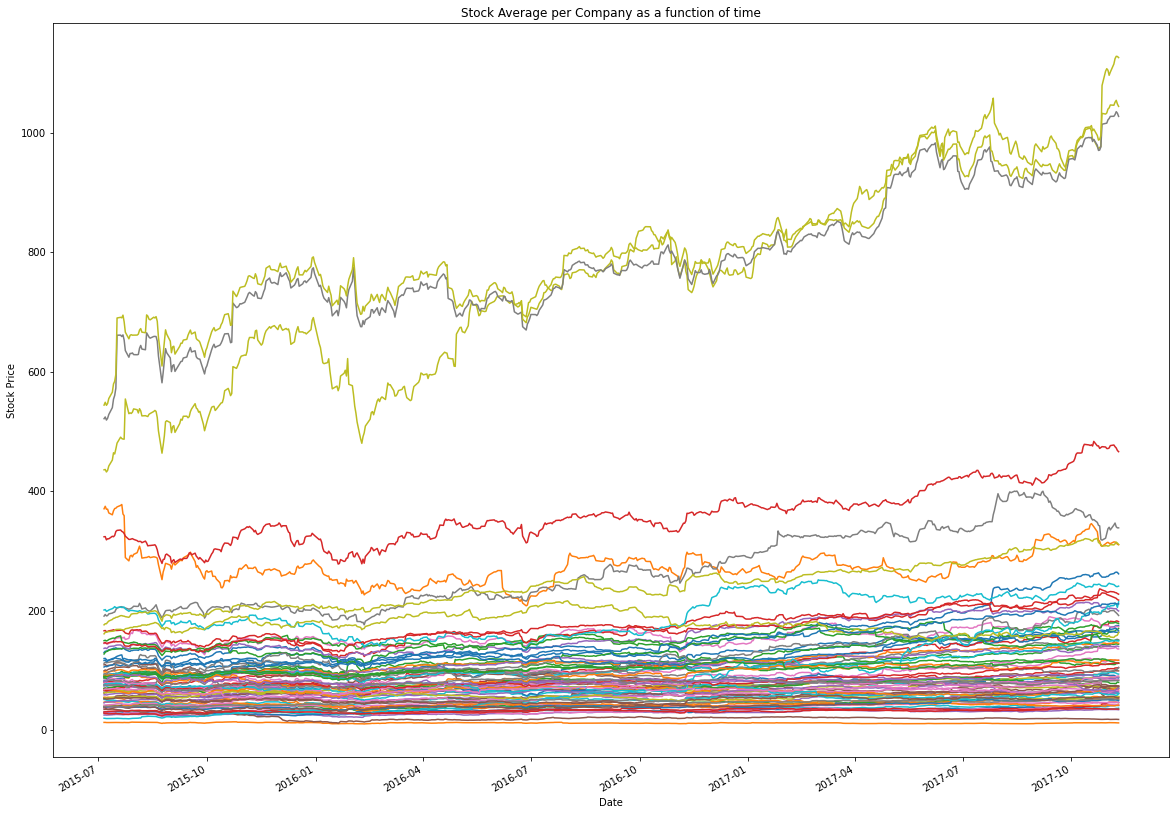

In [ ]:
# graph pivoted dataframe
m_cp_1_p.plot(title="Stock Average per Company as a function of time", legend=False, ylabel="Stock Price", figsize=(20,15))

From this graph, it looks like there are several outliers which seem to mirror each other in their growth trends. Most of the stock prices are below 200 in price. It appears that there might be a general upward trend in stock prices over time, but it's hard to say for sure from just this graph due to to heavy concentration of lines below the 200 mark.

In [45]:
m_cp = MASTER_DF.copy()
m_cp.head()

Date    Open    High  ...  Headquarters Location  Date first added    Founded
0 2015-07-06  145.19  146.78  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
1 2015-07-07  146.37  146.83  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
2 2015-07-08  145.38  145.78  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
3 2015-07-09  145.87  146.71  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
4 2015-07-10  146.01  147.06  ...    St. Paul, Minnesota        1976-08-09 1902-01-01

[5 rows x 13 columns]

Additional features that seem like they would be relevant would include the **Sector** and **Growth**, since some sectors may have been more profitable overall than other sectors. And **Growth** represents the percentage increase in stock value day to day. The companies that have high **Growth** represent the companies that were profitable and this is what our machine is trying to predict. In order to calculate **Growth** we will take (**Close** / **Open** - 1) * 100%.

In [ ]:
m_cp['Growth'] = (m_cp['Close'] / m_cp['Open'] - 1) * 100
m_cp.head()

Date    Open    High  ...  Compounded Growth  Volume Range    Growth
0 2015-07-06  145.19  146.78  ...           0.008555             0  0.778291
1 2015-07-07  146.37  146.83  ...           0.006039             0  0.184464
2 2015-07-08  145.38  145.78  ...          -0.018955             0 -0.894208
3 2015-07-09  145.87  146.71  ...          -0.038916             0 -0.562144
4 2015-07-10  146.01  147.06  ...          -0.013252             0  0.143826

[5 rows x 17 columns]

Additionally we would like to calculate the **Compounded Growth**, which we will calculate by:
$$\frac{100\%}{\mbox{Start Date Open Price}}\sum_{i=\mbox{start date}}^{\mbox{end date}}[i\mbox{th Date Close Price} - \mbox{Start Date Open Price}]$$ 

Basically, we are modeling how the stock prices on any given day compare to their initial stock price value, and we standarize it to their initial stock price value.

In [ ]:
# groupby will group the dataframe based on unique symbol values
# apply will modify the value of each grouping based on formula provided 
compounded_growth = m_cp.groupby('Symbol').apply(lambda x: (x['Close'] - float(x['Open'].head(1))) / float(x['Open'].head(1)))

# reset_index undoes the grouping, returning to original dataframe (keeping modifications)
compounded_growth = compounded_growth.reset_index()

m_cp['Compounded Growth'] = compounded_growth['Close']
m_cp.head()

Date    Open    High  ...  SE_N_Close  SE_N_Volume  Compounded Growth
0 2015-07-06  145.19  146.78  ...    0.459502     0.648269           0.008555
1 2015-07-07  146.37  146.83  ...    0.458969     0.631645           0.006039
2 2015-07-08  145.38  145.78  ...    0.463235     0.637736          -0.018955
3 2015-07-09  145.87  146.71  ...    0.461618     0.650706          -0.038916
4 2015-07-10  146.01  147.06  ...    0.459669     0.650893          -0.013252

[5 rows x 24 columns]

Now we will average (mean) the **Compounded Growth** across all companies within the same **Sector**. To do so, we will calculate: 


$$\frac{1}{\mbox{# of Companies in the Sector}}\sum_{\mbox{Companies in the Sector}}^{}[\mbox{Compounded Growth of Company}]$$ 

for each sector

In [ ]:
sectorlst = m_cp['GICS  Sector'].drop_duplicates()
daterange = m_cp['Date'].drop_duplicates()
growthplt = pd.DataFrame({'Date': daterange})

# Calculating unique average sector growth for each sector
for sector in sectorlst:
  m_sector = m_cp.loc[m_cp['GICS  Sector'] == sector]
  sector_growth = []

  # Calculating the average sector growth for each day
  # by summing up compounded growth for every company 
  # of a given sector for that given day
  for date in daterange:
    m_sector_day = m_sector.loc[m_cp['Date'] == date]
    average_growth = m_sector_day['Compounded Growth'].sum() / len(m_sector_day)
    sector_growth.append(average_growth)

  growthplt[sector] = sector_growth

growthplt.head()

Date  Industrials  Health Care  ...  Real Estate    Energy  Utilities
0 2015-07-06     0.007124     0.004889  ...     0.008498  0.005896   0.002159
1 2015-07-07     0.007279     0.014812  ...     0.026032  0.020491   0.012271
2 2015-07-08    -0.013627     0.000610  ...     0.012361  0.010383  -0.005829
3 2015-07-09    -0.015110     0.005726  ...     0.003533  0.009794  -0.005764
4 2015-07-10     0.003084     0.018934  ...    -0.009250  0.022347   0.000467

[5 rows x 11 columns]

In [ ]:
growthplt = growthplt.drop(columns = ['Date'])

Now we shall plot the **sector growth** vs **Date** 

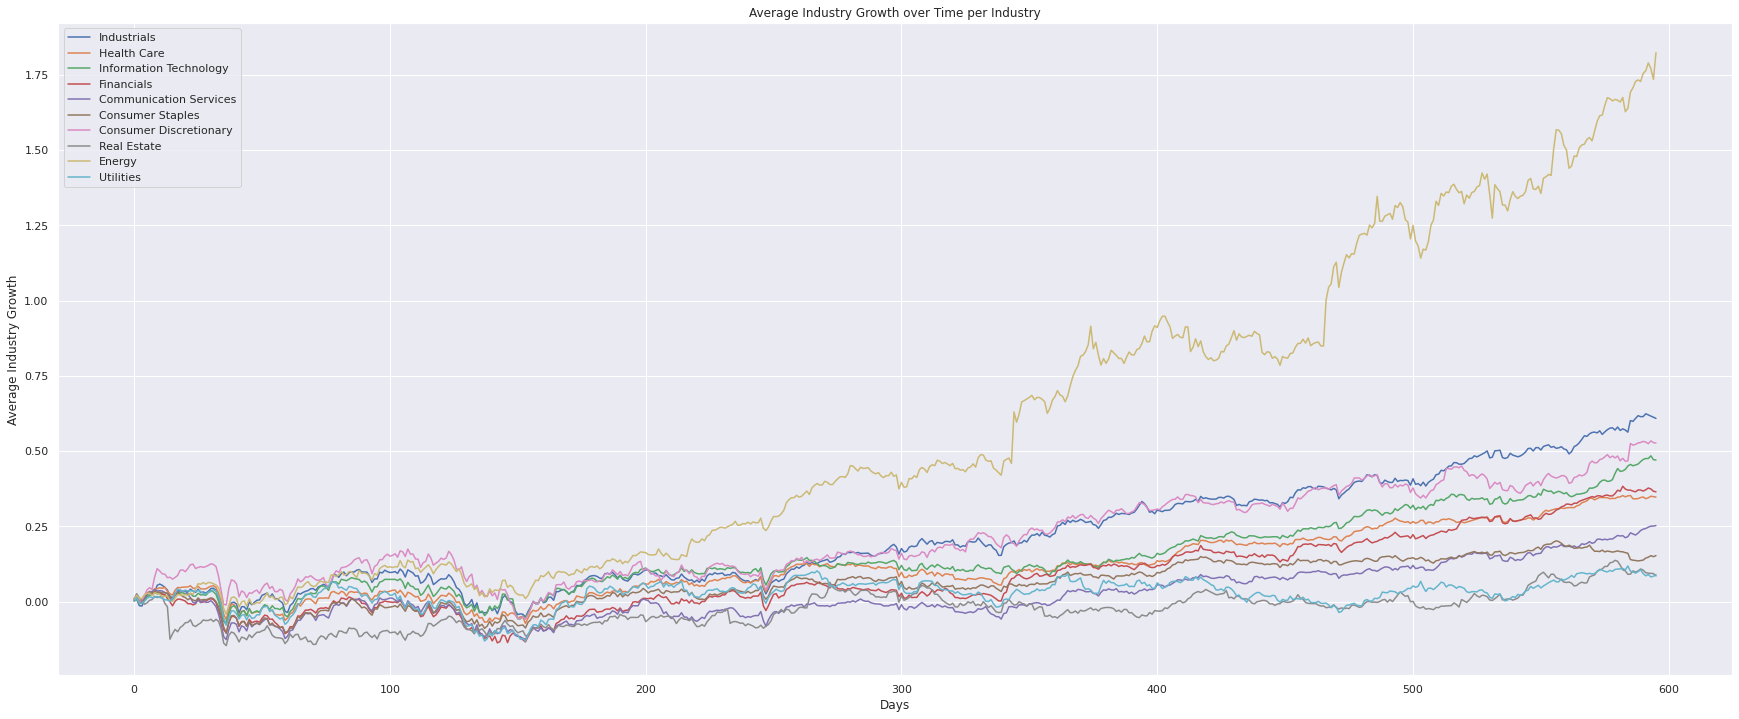

In [ ]:
growthplt.plot(figsize = (30, 12))
plt.xlabel('Days')
plt.ylabel('Average Sector Growth')
plt.title('Average Sector Growth over Time per Sector')

plt.show()

We will notice that the growth of each sector seems closely similar to each other; they seem to all fall under a similar trend (excluding energy). However, you should not be alarmed, since this still falls within our expectations. Typically speaking, the stock market reflects the economic situation of a nation. Therefore fluctuations within one sector will be closely modeled in the fluctuation within another sector. The exception to this is when some sector experiences more growth due to external factors, such as technological advancements and scientific breakthroughs. Since the energy sector seems to diverge from the trend; this might indicate that some breakthrough in energy production occurred during this time period or some national policy (such as the deregulation of this sector) improved the performance of this sector . 

Now lets look at how companies within the same **Sector** compare to each other. We will be creating 10 separate plots for each **Sector**, with the inclusion of the industry average for comparison in black.

In [ ]:
def make_sector_plot(sector):
  pplt = m_cp.loc[(m_cp['GICS  Sector'] == sector)].pivot(index = 'Date', columns = 'Symbol', values = 'Compounded Growth')
  pplt.plot(figsize = (30, 12))

  # plotting the average industry growth for comparison (in black so it stands out)
  plt.plot(daterange, growthplt[sector], color = 'black')

  plt.title(sector)
  plt.xlabel('Date')
  plt.ylabel('Compounded Growth')

  plt.show()

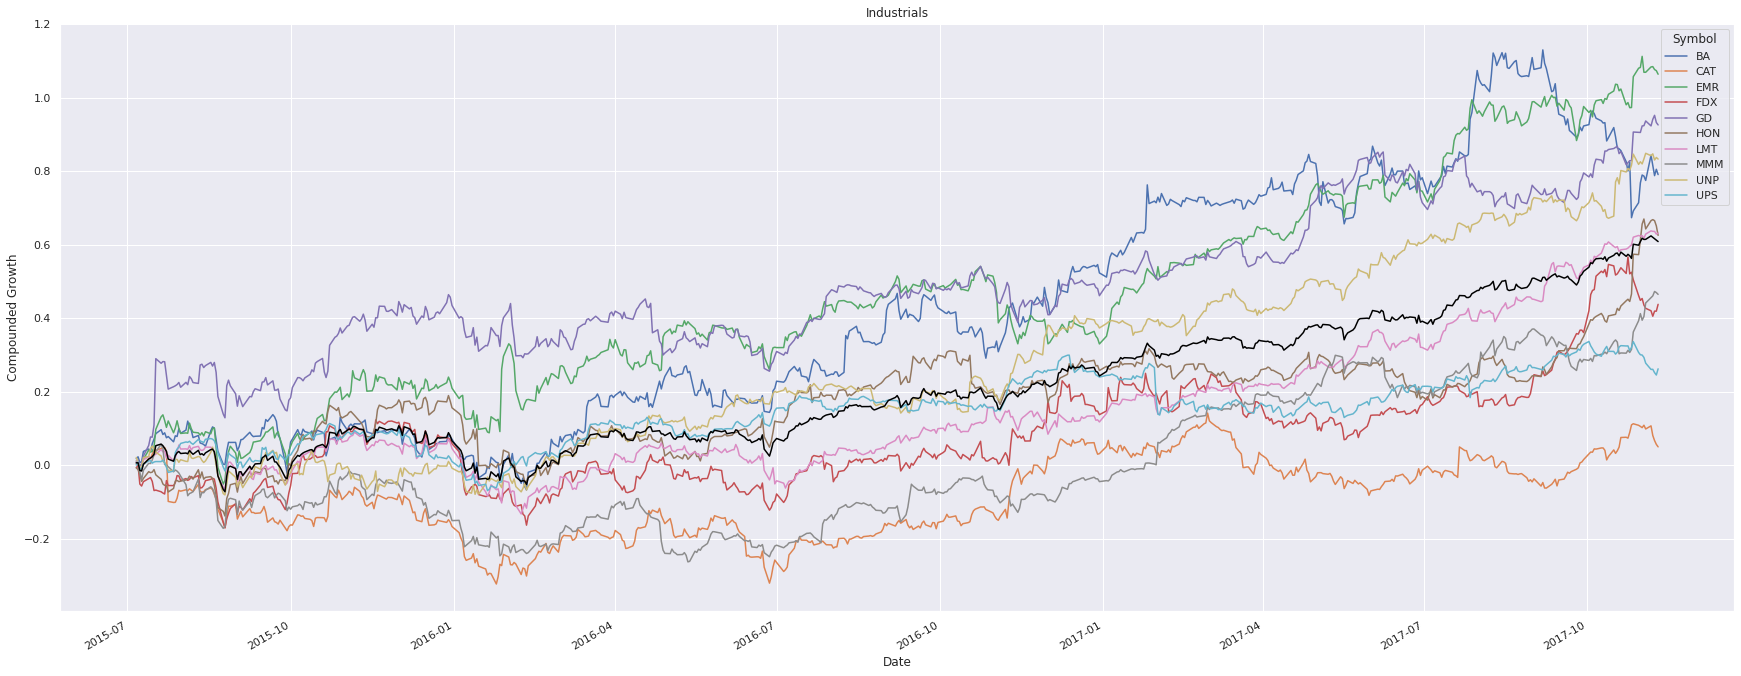

In [ ]:
# reindexing so that ith index corresponds to ith sector
sectorlst.index = range(len(sectorlst))

make_sector_plot(sectorlst[0])

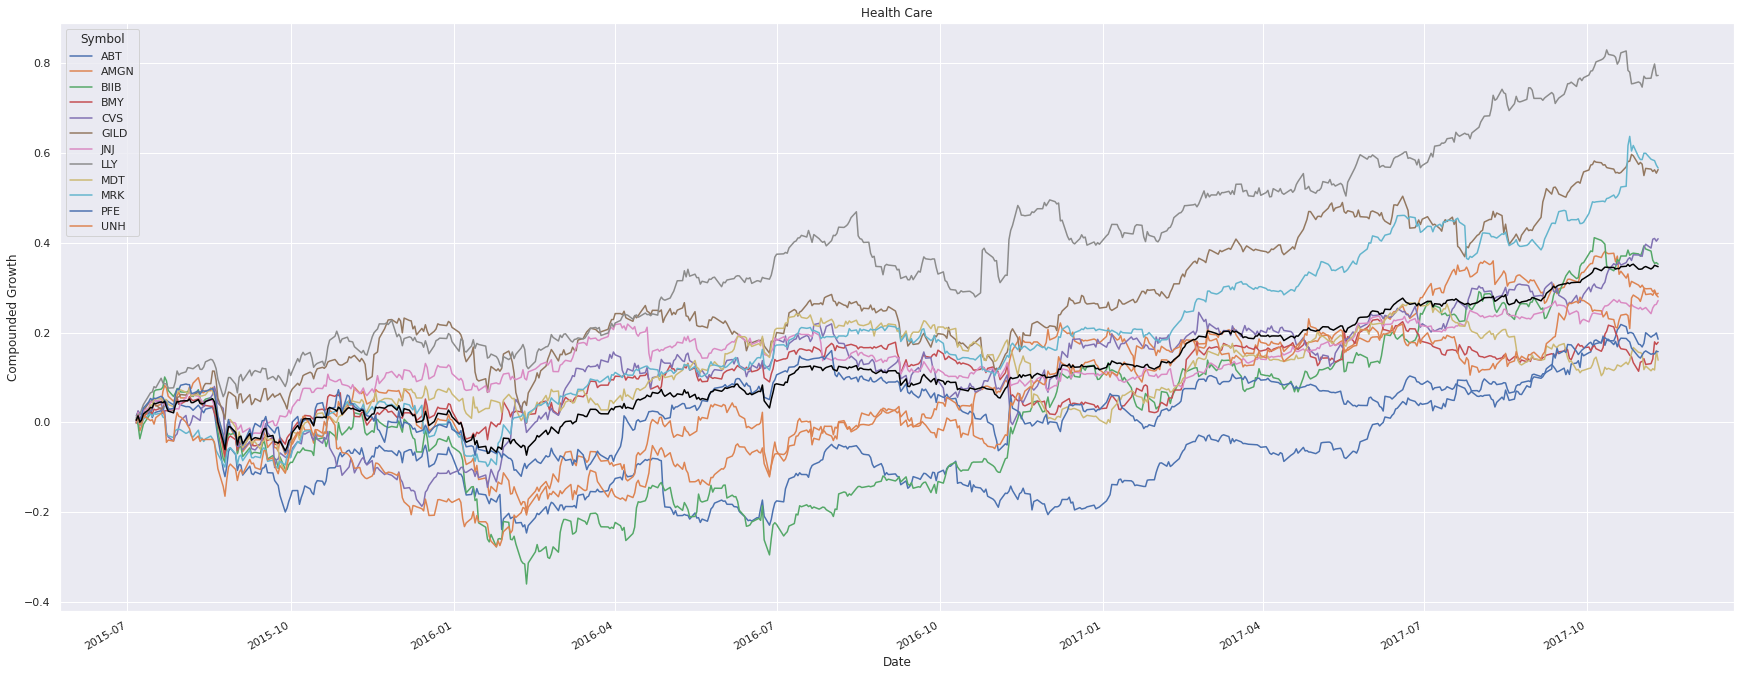

In [ ]:
make_sector_plot(sectorlst[1])

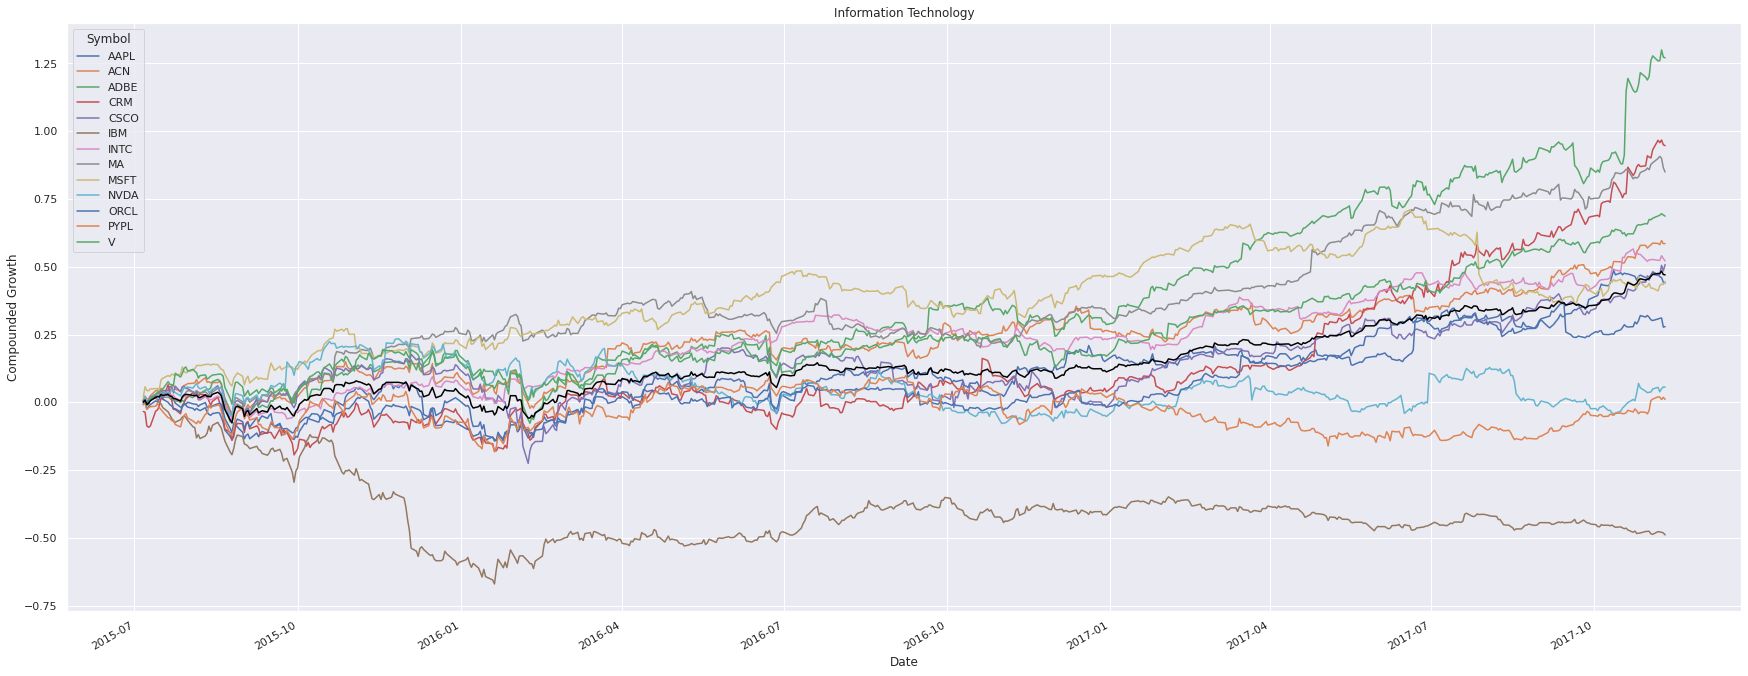

In [ ]:
make_sector_plot(sectorlst[2])

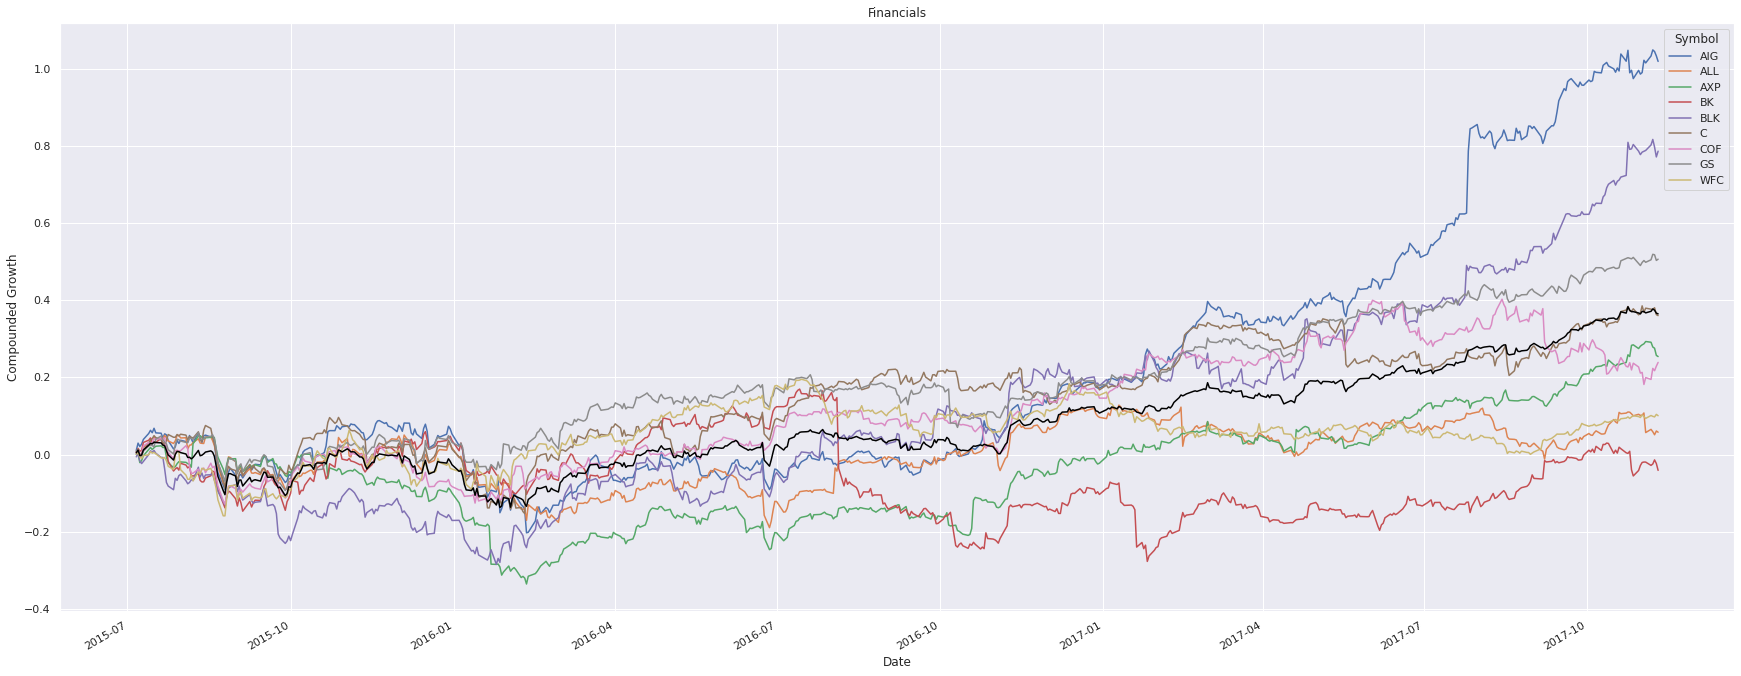

In [ ]:
make_sector_plot(sectorlst[3])

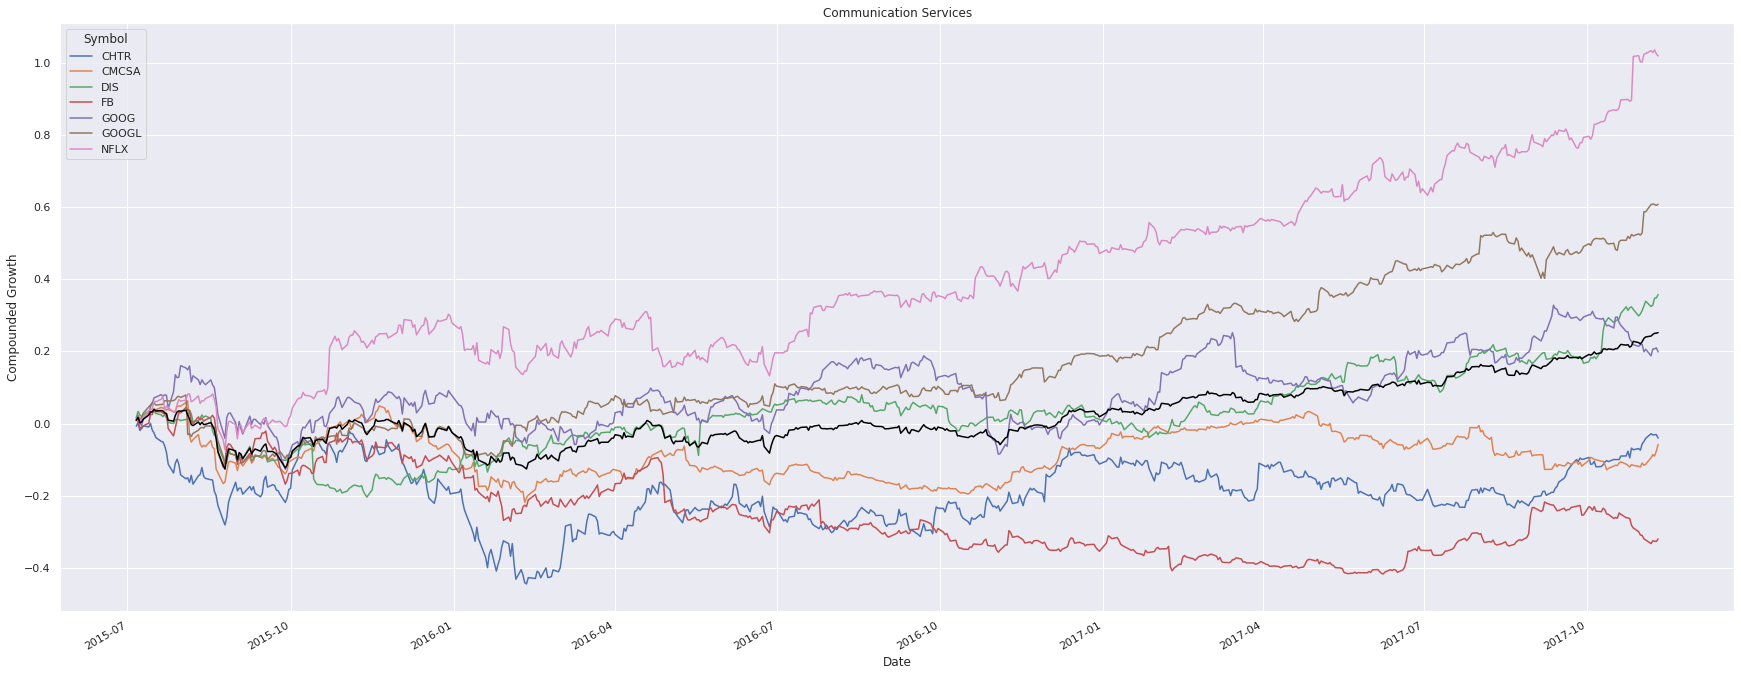

In [ ]:
make_sector_plot(sectorlst[4])

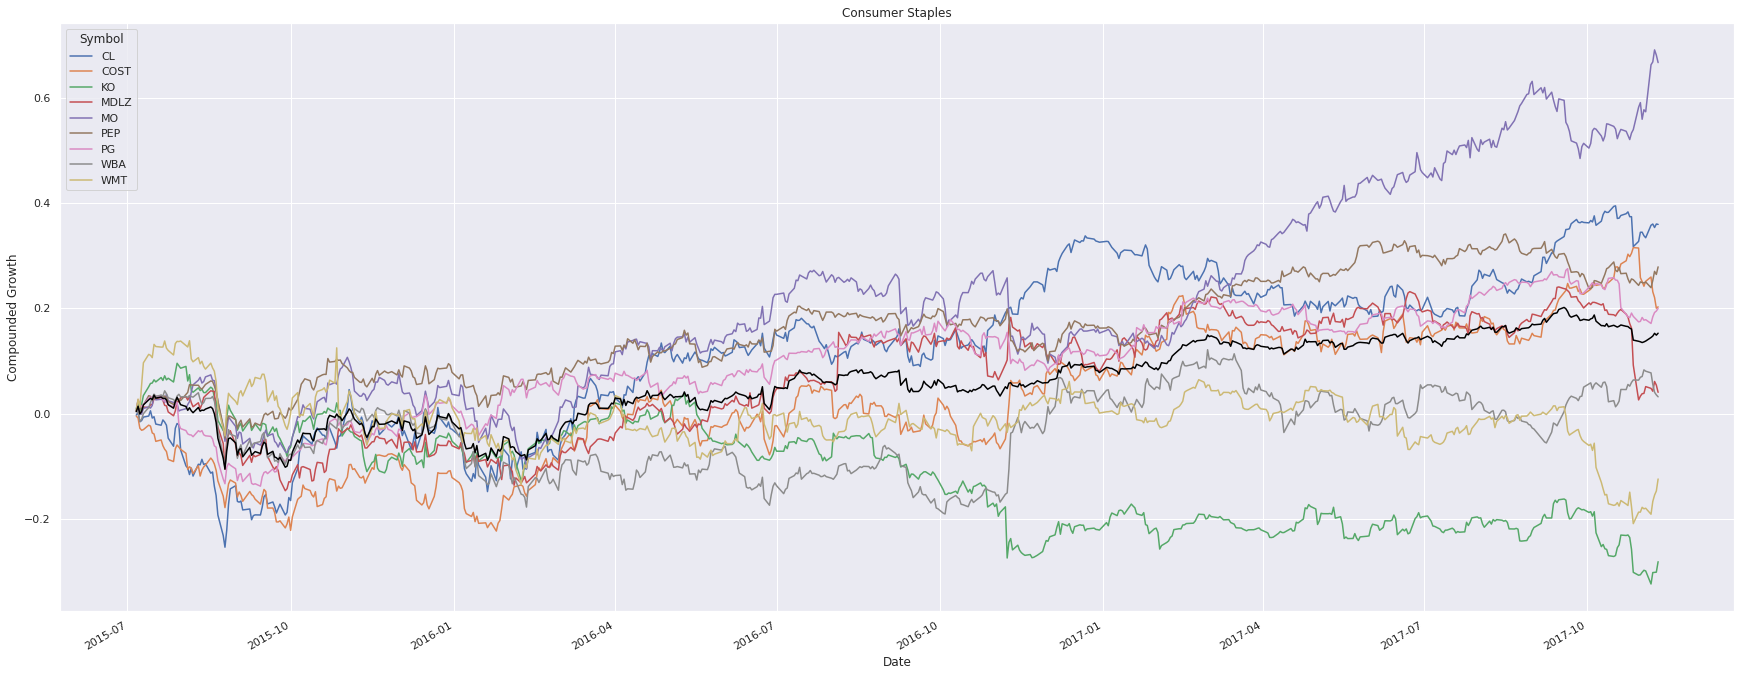

In [ ]:
make_sector_plot(sectorlst[5])

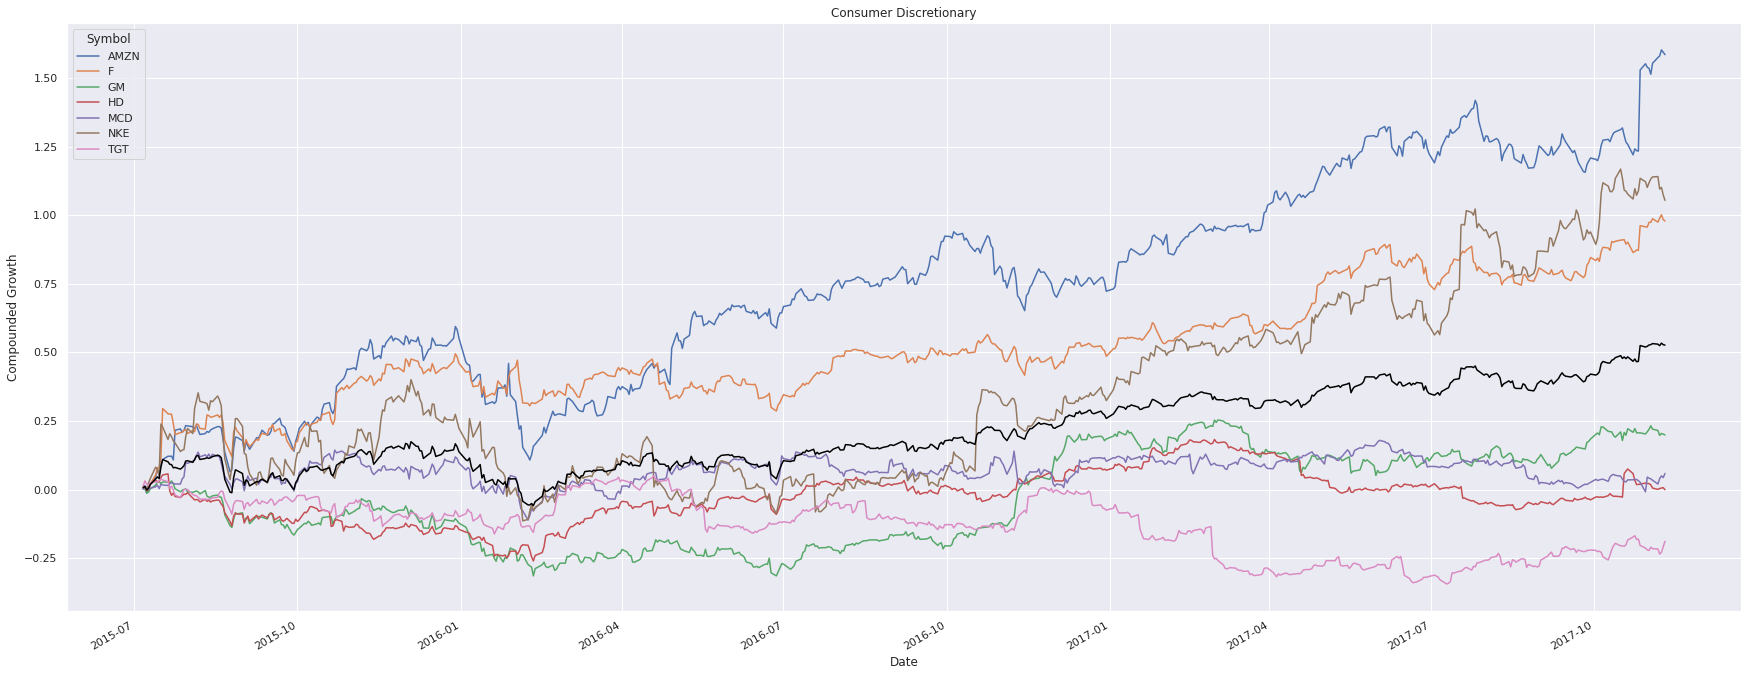

In [ ]:
make_sector_plot(sectorlst[6])

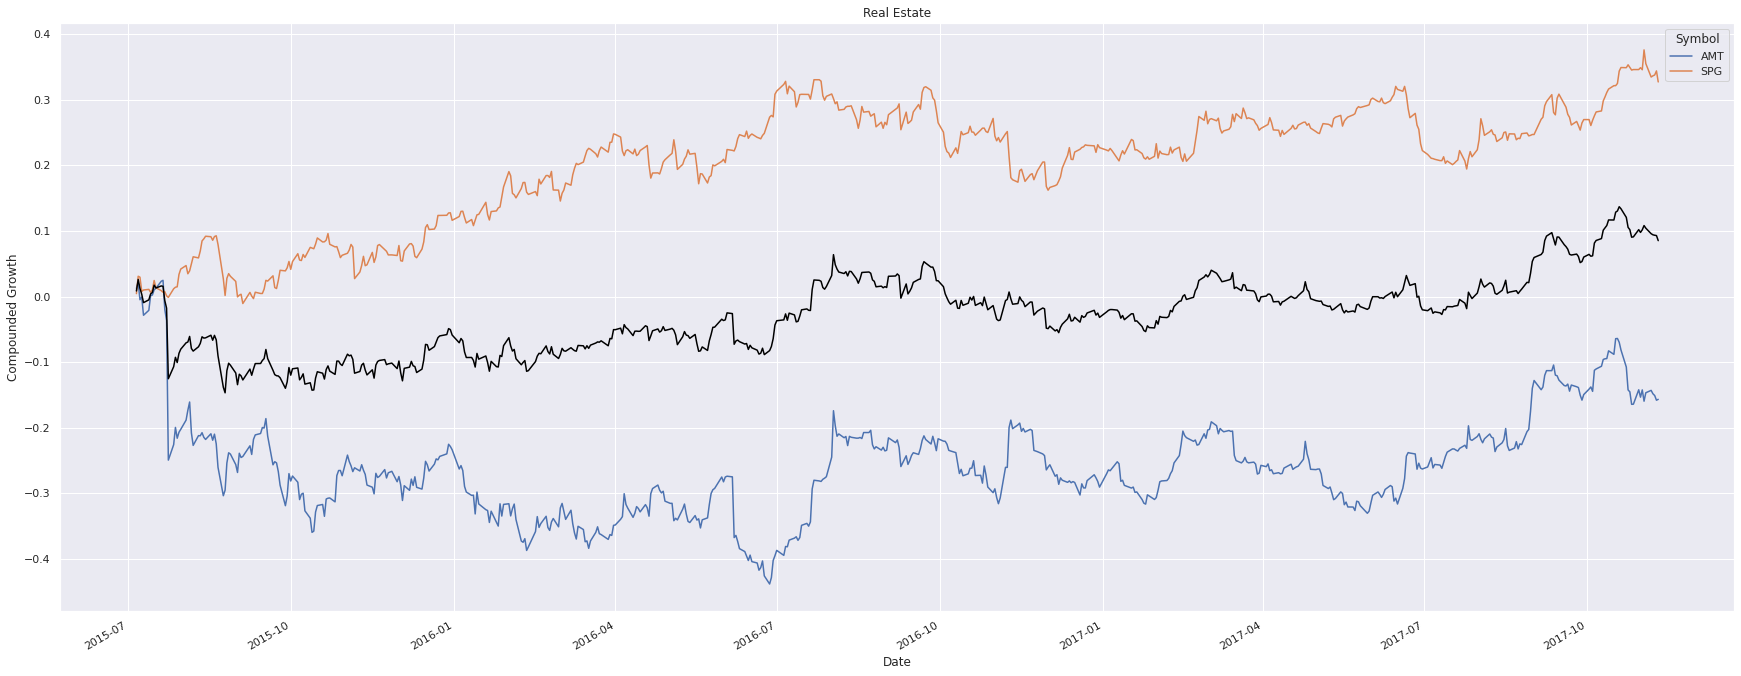

In [ ]:
make_sector_plot(sectorlst[7])

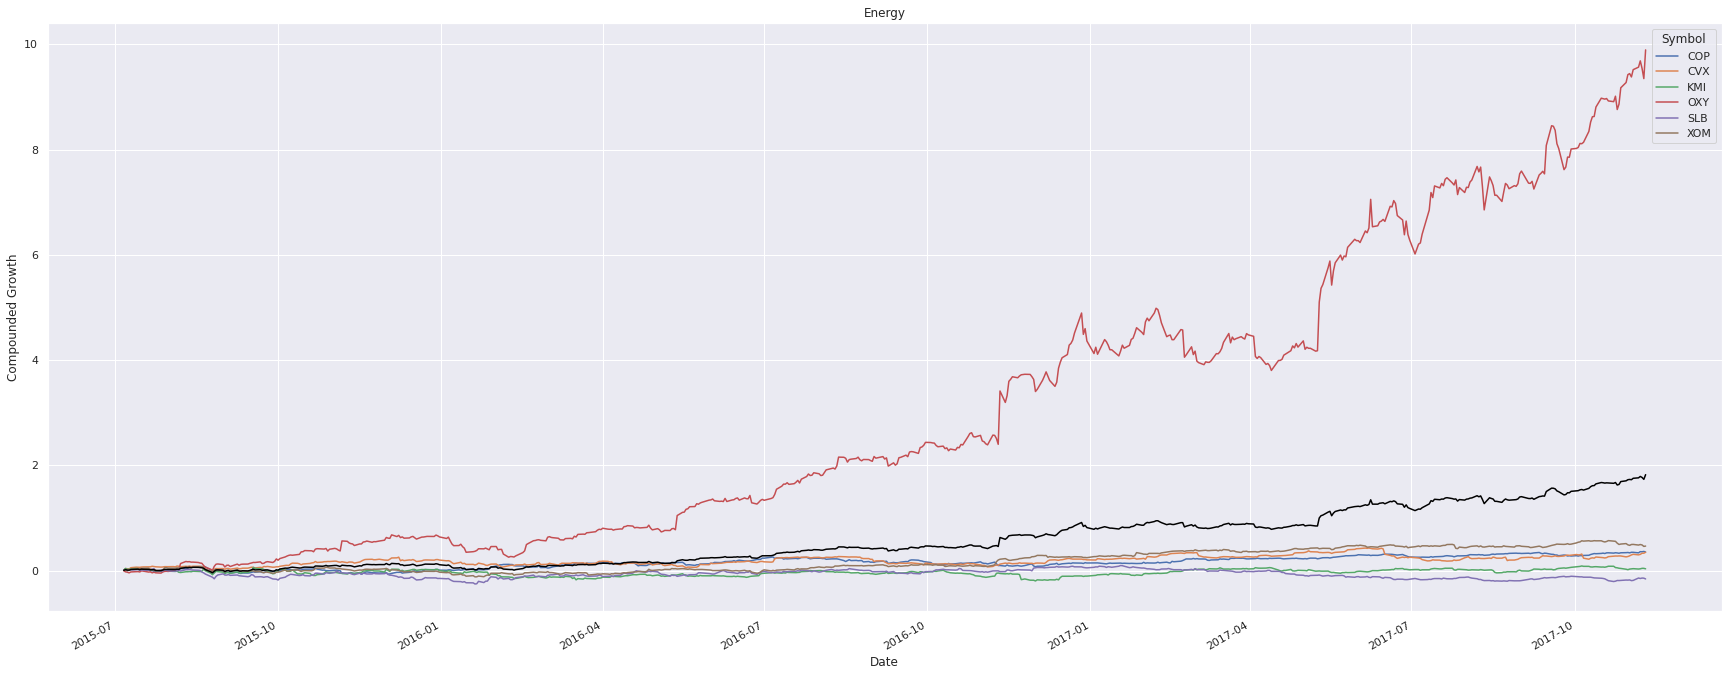

In [ ]:
make_sector_plot(sectorlst[8])

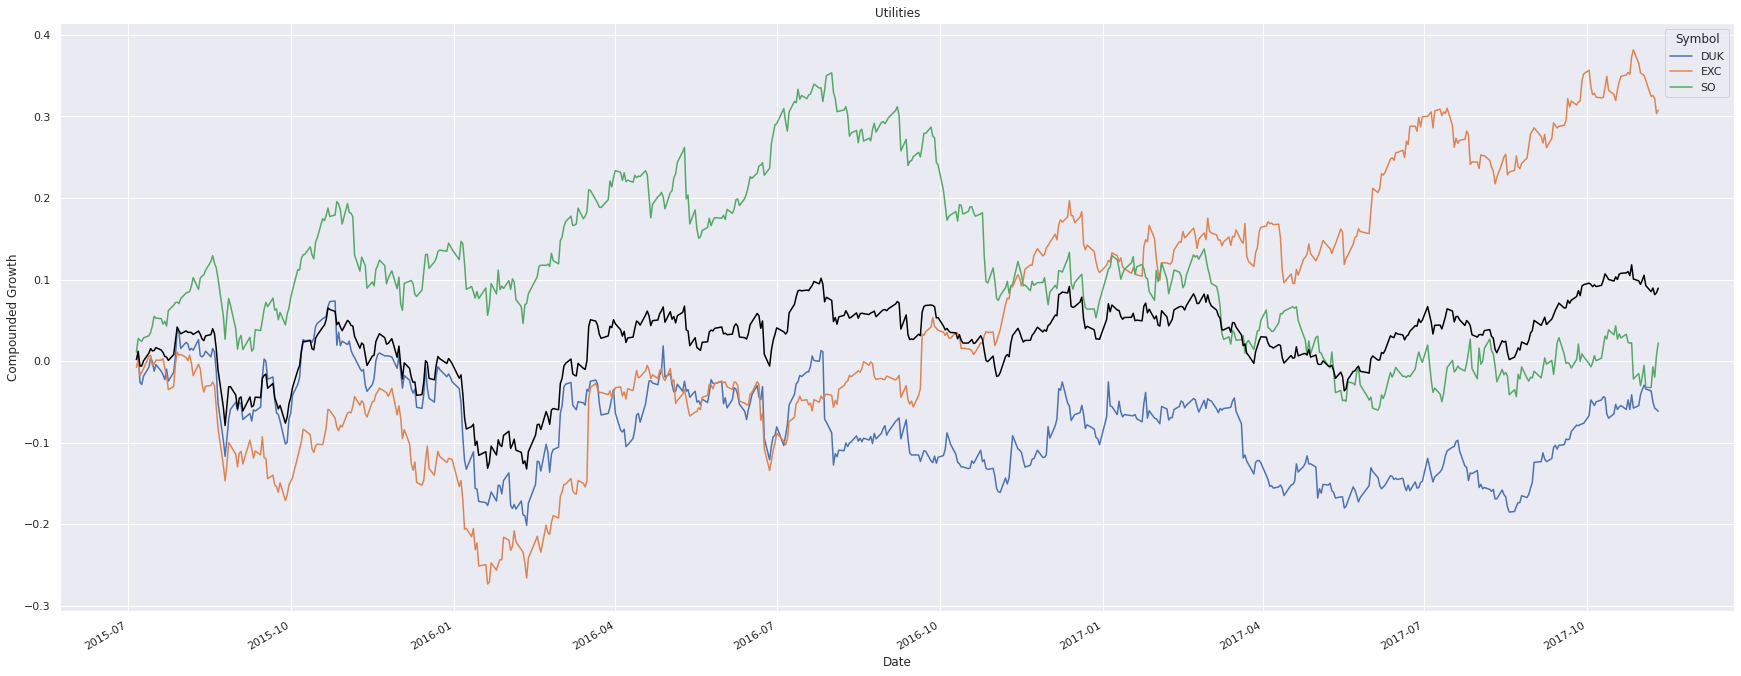

In [ ]:
make_sector_plot(sectorlst[9])

We will notice immediately that the reason behind the massive average industry growth of the energy sector, is because of the company OXY. This might indicate this company is highly profitable, or that this company is overrated. Furthermore we can notice how some companies are underperforming within their sector; this may indicate that they are losing in profitiability or that they are underrated. 


Additionally, we learn that the profitability of companies within different sector vary significantly. We find that utilities and real estate experience the least growth, whereas energy experiences significant growth. From this we are drawn to believe that the sector a company is from will influence the profitability of that company.

The **Volume** of stocks traded has also been noted to indicate shifts in trader interest in a company. For example, when there is a spike in **Volume** this could be due to panic that a company has loss profitability or has gained in profitability, so everyone is scrambling to buy or sell stocks. Therefore we will shall create a distribution plot of the **Growth** vs **Volume**. First we will define interval ranges of 10 million for the **Volume** of stocks traded.

In [ ]:
interval_range = 10000000
m_cp['Volume Range'] = m_cp['Volume'].apply(lambda x: int(x / interval_range))
m_cp.head()

Date    Open    High  ...    Profit  Compounded Growth  Volume Range
0 2015-07-06  145.19  146.78  ...  0.778291           0.008555             0
1 2015-07-07  146.37  146.83  ...  0.184464           0.006039             0
2 2015-07-08  145.38  145.78  ... -0.894208          -0.018955             0
3 2015-07-09  145.87  146.71  ... -0.562144          -0.038916             0
4 2015-07-10  146.01  147.06  ...  0.143826          -0.013252             0

[5 rows x 16 columns]

Now we build distribution plots, to do this we will use python's Seaborn library. For more information on building violin plots https://seaborn.pydata.org/generated/seaborn.violinplot.html

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


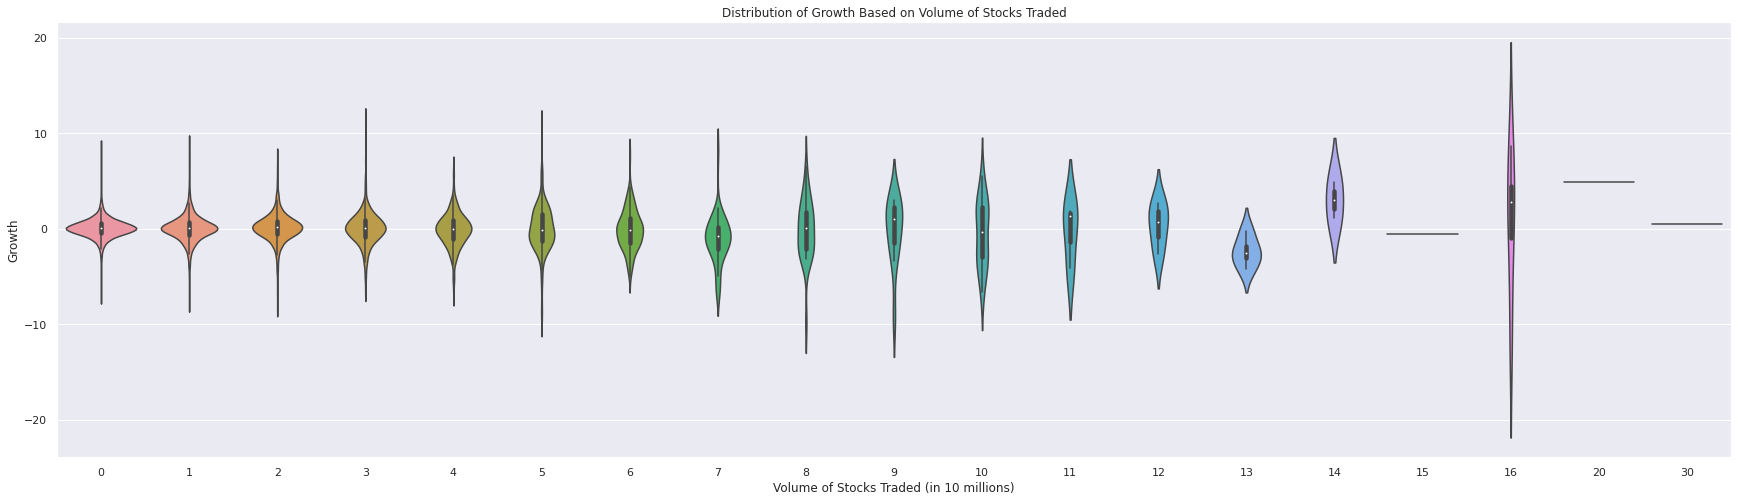

In [ ]:
sns.set(rc = {'figure.figsize':(30,8)})
ax = sns.violinplot('Volume Range', 'Growth', data = m_cp)
ax.set(xlabel = 'Volume of Stocks Traded (in 10 millions)', ylabel = 'Growth', title = 'Distribution of Growth Based on Volume of Stocks Traded')

plt.show()

The variance and range of the distribution seems to increase as the volume of stocks traded increases. However, this may be due to fewer data points for large volume trading. 

Therefore we will make a scatter plot for each individual data point. We will use the matplotlib library to do this. To learn more visit this site https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.scatter.html

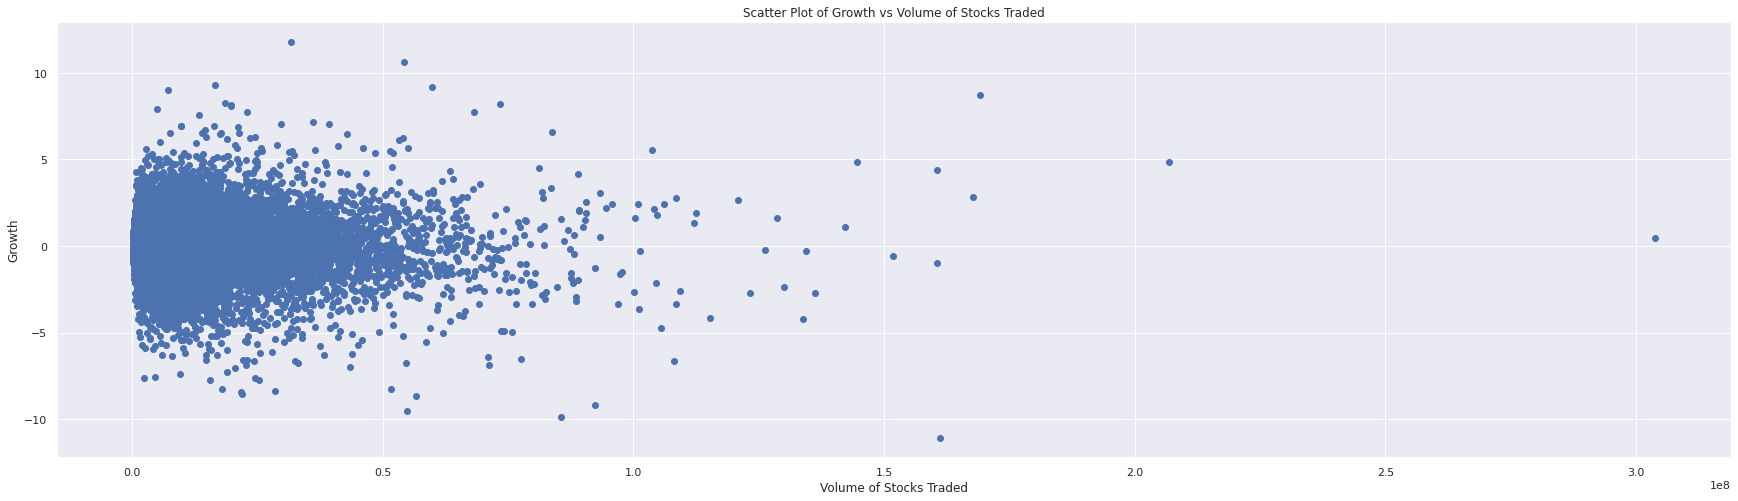

In [ ]:
plt.scatter('Volume', 'Growth', data = m_cp)
plt.xlabel('Volume of Stocks Traded')
plt.ylabel('Growth')
plt.title('Scatter Plot of Growth vs Volume of Stocks Traded')

plt.show()

As we had feared, the variation can largely be explained by the lack of data points. However, we might find a more meaningful trend when we look instead at the change in volume of stocks traded. In order to calculate this we will just shift the volumes by 1 day and subtract out the original copy.

In [ ]:
# After grouping, volume[i + 1] - volume[i] is assigned to change_volume[i + 1] for all i
change_volume = m_cp.groupby('Symbol').apply(lambda x: x['Volume'].shift(1) - x['Volume'])
change_volume = change_volume.reset_index()
m_cp['Volume Change'] = change_volume['Volume']

m_cp.head()

Date    Open    High  ...  Volume Range    Growth  Volume Change
0 2015-07-06  145.19  146.78  ...             0  0.778291            NaN
1 2015-07-07  146.37  146.83  ...             0  0.184464    -19790224.0
2 2015-07-08  145.38  145.78  ...             0 -0.894208    -14475919.0
3 2015-07-09  145.87  146.71  ...             0 -0.562144    -18686831.0
4 2015-07-10  146.01  147.06  ...             0  0.143826     18065663.0

[5 rows x 18 columns]

Time to build the scatter plot of **Growth** vs **Volume Change** 

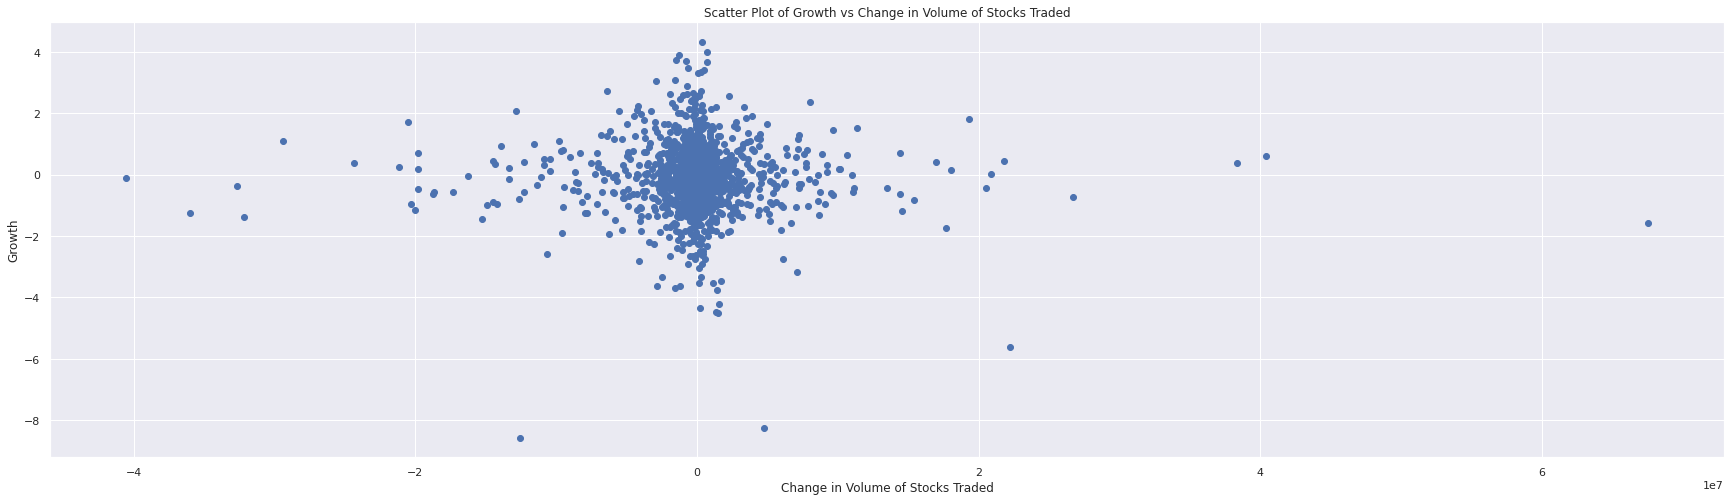

In [ ]:
plt.scatter('Volume Change', 'Growth', data = m_cp)
plt.xlabel('Change in Volume of Stocks Traded')
plt.ylabel('Growth')

plt.title('Scatter Plot of Growth vs Change in Volume of Stocks Traded')

plt.show()

The data seems to indicate the opposite of what our intuition predicted. Large change in volume of trade are typically met with low growth, excluding a few exceptions. However, the largest growth or loss are observed in those with little to no change in volume of stocks traded. From this we find that there seems to be no correlation between growth and volume. 

Now to set up a precursor for later analysis, we will average out the growth across all companies, for a metric of how well we would like to perform over this period of time, when testing our model. 

In order to do this we will calculate:
$$\frac{1}{\mbox{# of Companies}}\sum_{\mbox{All Companies}}^{}[\mbox{Compounded Growth of Company}]$$ 

This formula should look familiar, since its the same one used to calculate the average per sector, but instead we now want the average for the S&P100.

In [ ]:
all_growth = []

# summing of compounded growth of all companies for each day to calculate
# average industry growth
for date in daterange:
  m_sector_day = m_sector.loc[m_cp['Date'] == date]
  average_growth = m_sector_day['Compounded Growth'].sum() / len(m_sector_day)
  all_growth.append(average_growth)

growthplt['All'] = all_growth
growthplt.head()

Industrials  Health Care  ...  Utilities       All
0     0.007124     0.004889  ...   0.002159  0.002159
1     0.007279     0.014812  ...   0.012271  0.012271
2    -0.013627     0.000610  ...  -0.005829 -0.005829
3    -0.015110     0.005726  ...  -0.005764 -0.005764
4     0.003084     0.018934  ...   0.000467  0.000467

[5 rows x 11 columns]

Now we plot this against time.

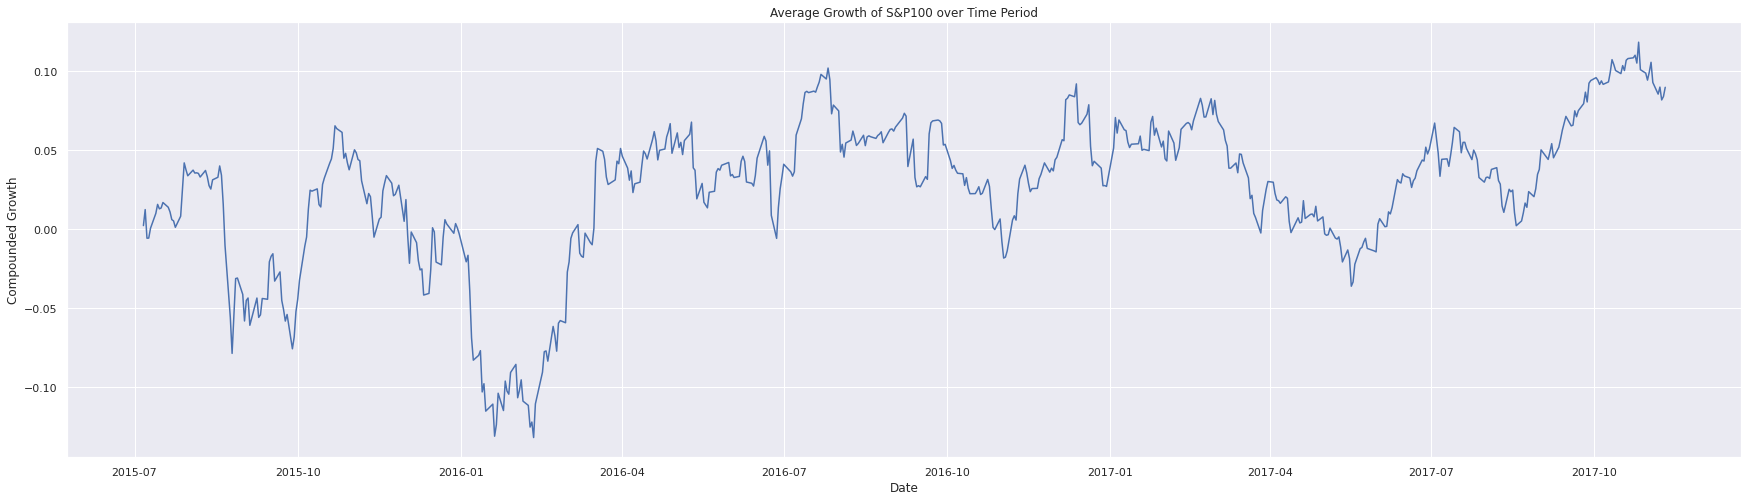

In [ ]:
plt.plot(daterange, growthplt['All'])
plt.xlabel('Date')
plt.ylabel('Compounded Growth')
plt.title('Average Growth of S&P100 over Time Period')

plt.show()

And the exact measure of how much the S&P100 grew over our designated time period, would just be the average **Compounded Growth** value on the end of this period.

In [ ]:
growthplt['All'][-1:]

595    0.089655
Name: All, dtype: float64

Which would be around 9%. We will also calculate the average magnitude of Growth each day, to approximate how much profit correct predictions vs incorrect predictions in the market would be. 

In order to calculate this we will:
$$\frac{1}{\mbox{# of Entries}}\sum_{\mbox{All Entries}}^{}[\mbox{|Growth of Entry|}]$$ 

In [ ]:
sum_magnitude = 0

for i in m_cp['Growth']:
  sum_magnitude += abs(i)

print('Sum magnitude of growth: ', sum_magnitude)
print('Average magnitude of growth: ', sum_magnitude / len(m_cp))

Sum magnitude of growth:  37327.34809400359
Average magnitude of growth:  0.8029458805283856


From this we find that for each correct prediction we expect to see an increase in profit of around 0.8%.

## Analysis, hypothesis testing, & ML

In this section, we will apply a neural network to predict the opening price of any given stock given the open, high, low, closing, and volume of that stock in previous days. The model used here is based on the TensorFlow Kertas library tutorial, which is linked here: https://www.tensorflow.org/guide/keras/sequential_model

### Designing Model

Since the neural net (NN) can only take a set number of inputs, we will have to choose a limit for the backlog of stock data that we feed into the model. For now, we'll set this limit to be 20 days.

In [43]:
backlog = dt.timedelta(days=20)
backlog.days

20

Now that we've set the backlog, let's consider how the data will be passed in and what sort of output we should expect. This will help us determine the shape of our model.

For input, for each company, there will be 20 days worth of data with each day containing the five metrics: open, high, low, close, and volume. This means that for each company, we'll need 100 nodes in the input layer. Taking a look at the number of companies we have:

In [46]:
len(m_cp['Symbol'].unique())

78

We have 78 companies, so the input layer will need to have 7810 nodes as input. We have an extra 10 nodes to denote the industry of the company whose stock we're interested in.

For output, we'll just have 2 nodes, one holding the probability that that company's opening stock will have increased and one holding the probability that that company's opening stock did not increase.

So, based on all of that, we can build our model:

In [47]:
model = keras.Sequential([
    keras.layers.Dense(backlog.days*5*len(m_cp['Symbol'].unique()) + 10),  # input layer (1)
    keras.layers.Dense(len(m_cp['Symbol'].unique())*backlog.days, activation='relu'),   # hidden layer (2)
    keras.layers.Dense(2, activation='softmax')                                     # output layer (3)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Notice that we also have a hidden layer between our input and output layer. In this case, we just arbitrarily decided that this hidden layer should have 1560 nodes.

All the layers are densely connected, which means that every node fomr the previous layer is connected to every node in the next layer.

With this, our model is build and ready to be trained.

### Preparing Data

Now that we have our model, we need to prepare our data to fit in into our model. More specifically we need to take the data from our master dataframe and split it into a set of x and y values which correspond with the input and output of the model. Let's start by first making a copy of the Master dataframe to work with:

In [48]:
m_cp = MASTER_DF.copy()
m_cp.head()

Date    Open    High  ...  Headquarters Location  Date first added    Founded
0 2015-07-06  145.19  146.78  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
1 2015-07-07  146.37  146.83  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
2 2015-07-08  145.38  145.78  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
3 2015-07-09  145.87  146.71  ...    St. Paul, Minnesota        1976-08-09 1902-01-01
4 2015-07-10  146.01  147.06  ...    St. Paul, Minnesota        1976-08-09 1902-01-01

[5 rows x 13 columns]

All values that the NN accepts as input and outputs are within the [0,1]. But our data potentially spans the entire real number line. In order to bring everything closer to the [0,1] range, we'll create normalized versions of the columns we'll use:

In [49]:
m_cp['N_Open'] = (m_cp['Open'].mean() - m_cp['Open']) / m_cp['Open'].std()
m_cp['N_High'] = (m_cp['High'].mean() - m_cp['High']) / m_cp['High'].std()
m_cp['N_Low'] = (m_cp['Low'].mean() - m_cp['Low']) / m_cp['Low'].std()
m_cp['N_Close'] = (m_cp['Close'].mean() - m_cp['Close']) / m_cp['Close'].std()
m_cp['N_Volume'] = (m_cp['Volume'].mean() - m_cp['Volume']) / m_cp['Volume'].std()

m_cp.head()

Date    Open    High     Low  ...    N_High     N_Low   N_Close  N_Volume
0 2015-07-06  145.19  146.78  145.13  ... -0.157904 -0.162750 -0.162348  0.611441
1 2015-07-07  146.37  146.83  144.53  ... -0.158237 -0.158693 -0.164494  0.539279
2 2015-07-08  145.38  145.78  144.07  ... -0.151246 -0.155582 -0.147324  0.565552
3 2015-07-09  145.87  146.71  145.05  ... -0.157438 -0.162209 -0.153830  0.622144
4 2015-07-10  146.01  147.06  145.78  ... -0.159768 -0.167146 -0.161677  0.622966

[5 rows x 18 columns]

Now, everything is closer to [0,1], but not completely within the acceptable range. So, we'll use a sigmoid encoding to force everything to fit within the appropriate range.

In [50]:
m_cp['SE_N_Open'] = 1 / (1 + np.exp(-m_cp['N_Open']))
m_cp['SE_N_High'] = 1 / (1 + np.exp(-m_cp['N_High']))
m_cp['SE_N_Low'] = 1 / (1 + np.exp(-m_cp['N_Low']))
m_cp['SE_N_Close'] = 1 / (1 + np.exp(-m_cp['N_Close']))
m_cp['SE_N_Volume'] = 1 / (1 + np.exp(-m_cp['N_Volume']))

m_cp.head()

Date    Open    High  ...  SE_N_Low  SE_N_Close  SE_N_Volume
0 2015-07-06  145.19  146.78  ...  0.459402    0.459502     0.648269
1 2015-07-07  146.37  146.83  ...  0.460410    0.458969     0.631645
2 2015-07-08  145.38  145.78  ...  0.461183    0.463235     0.637736
3 2015-07-09  145.87  146.71  ...  0.459536    0.461618     0.650706
4 2015-07-10  146.01  147.06  ...  0.458311    0.459669     0.650893

[5 rows x 23 columns]

Now that all the considered data is within the appropriate range, we will pivot this data by date and symbol to focus on the values we care about:

In [51]:
m_cp_p = m_cp.pivot(index='Date', columns='Symbol', values=['SE_N_Open', 'SE_N_High', 'SE_N_Low', 'SE_N_Close', 'SE_N_Volume'])
m_cp_p.head()

SE_N_Open                      ... SE_N_Volume                    
Symbol          AAPL       ABT       ACN  ...         WFC       WMT       XOM
Date                                      ...                                
2015-07-06  0.504787  0.624515  0.552369  ...    0.402312  0.434129  0.396888
2015-07-07  0.503244  0.623117  0.550245  ...    0.302821  0.386458  0.301049
2015-07-08  0.505524  0.623447  0.547666  ...    0.371660  0.505556  0.439645
2015-07-09  0.506530  0.623354  0.548683  ...    0.354174  0.481895  0.389558
2015-07-10  0.509581  0.623607  0.548794  ...    0.362758  0.563067  0.477709

[5 rows x 390 columns]

Now, let's filter out the corresponding x's and y's. Each y will contain either a 0 or a 1, representing the presencse of an increase in opening stock price. For each element in y, there will be a corresponding array in x of length 7810 containing the encoding for the industry and the 20 previous days of market data.

But, first, we need to pick a company from our 78 options:

In [52]:
options = m_cp['Symbol'].unique()
options.sort()
options

array(['AAPL', 'ABT', 'ACN', 'ADBE', 'AIG', 'ALL', 'AMGN', 'AMT', 'AMZN',
       'AXP', 'BA', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CHTR', 'CL',
       'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'DIS',
       'DUK', 'EMR', 'EXC', 'F', 'FB', 'FDX', 'GD', 'GILD', 'GM', 'GOOG',
       'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KMI', 'KO',
       'LLY', 'LMT', 'MA', 'MCD', 'MDLZ', 'MDT', 'MMM', 'MO', 'MRK',
       'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'OXY', 'PEP', 'PFE', 'PG',
       'PYPL', 'SLB', 'SO', 'SPG', 'TGT', 'UNH', 'UNP', 'UPS', 'V', 'WBA',
       'WFC', 'WMT', 'XOM'], dtype=object)

We decided to just go with 'AAPL' for our tutorial.

In [53]:
target_company = 'AAPL'

Here, we'll also do some prep work for encoding industries:

In [54]:
def encode_target_industry():
  target_industry = m_cp[m_cp['Symbol'] == target_company]['GICS  Sector'].unique()[0]
  industries = m_cp['GICS  Sector'].unique()
  for i in range(len(industries)):
    if industries[i] == target_industry:
      break
  encoding = np.zeros(10)
  encoding[i] = 1
  return encoding

Now, time to prepare the x and y data from the dataframe:

In [55]:
xs = []
ys = []

for i in range(m_cp_p.shape[0] - 20):
  ### prepare xs
  x = np.array([])
  # handle industry stuff
  x = np.append(x, encode_target_industry())
  # handle prev 20 days data
  for j in range(20):
    params = np.append(
        [m_cp_p.iloc[i + j]['SE_N_Open']],
        np.append(
            [m_cp_p.iloc[i + j]['SE_N_High']],
            np.append(
                [m_cp_p.iloc[i + j]['SE_N_Low']],
                np.append(
                    [m_cp_p.iloc[i + j]['SE_N_Close']],
                    [m_cp_p.iloc[i + j]['SE_N_Volume']],
                )
            )
        )
    )
    x = np.append(x, params)
  xs += [x]

  # prepare ys
  if m_cp_p.iloc[i + 20]['SE_N_Open']['AAPL'] > m_cp_p.iloc[i + 19]['SE_N_Close']['AAPL']:
    ys += [1]
  else:
    ys += [0]

np_xs = np.array(xs)
np_ys = np.array(ys)

Now, let's verify that the chape for both np_xs and np_ys are correct:

In [56]:
np_xs.shape

(576, 7810)

In [57]:
np_ys.shape

(576,)

The shape is as expected and we can see that we have 576 sets of x y data. From this, we'll choose a certain portion to be training data and a certain portion to be testing data. Preferably, we would like the training data to be ~10 times larger than the testing data.

In [58]:
split_index = math.floor(np_ys.shape[0]/11*10)

train_xs = np_xs[:split_index]
train_ys = np_ys[:split_index]

test_xs = np_xs[split_index:]
test_ys = np_ys[split_index:]

Now that we have our model, training data, and testing data, we can move on to fitting our model.

### Fitting Model

The TensorFlow library handles all the fitting for us, and will follow the shape and optimization configurations that we established in the designing model section. The only new thing we need to input is the number of epochs, which is just the number of times the model goes through our training data in the learning process.

But first, let's verify the shape of the training sets:

In [59]:
train_xs.shape

(523, 7810)

In [60]:
train_ys.shape

(523,)

And now, to fit the model:

In [61]:
model.fit(train_xs, train_ys, epochs=80)  

Epoch 1/80
17/17 [==============================] - 9s 451ms/step - loss: 71.3265 - accuracy: 0.5063
Epoch 2/80
17/17 [==============================] - 8s 460ms/step - loss: 17.4929 - accuracy: 0.4826
Epoch 3/80
17/17 [==============================] - 8s 461ms/step - loss: 17.3955 - accuracy: 0.5284
Epoch 4/80
17/17 [==============================] - 8s 466ms/step - loss: 10.8554 - accuracy: 0.5544
Epoch 5/80
17/17 [==============================] - 8s 455ms/step - loss: 1.9552 - accuracy: 0.4969
Epoch 6/80
17/17 [==============================] - 8s 454ms/step - loss: 1.9658 - accuracy: 0.5171
Epoch 7/80
17/17 [==============================] - 8s 454ms/step - loss: 1.1666 - accuracy: 0.5004
Epoch 8/80
17/17 [==============================] - 8s 457ms/step - loss: 1.1108 - accuracy: 0.5265
Epoch 9/80
17/17 [==============================] - 8s 457ms/step - loss: 0.9079 - accuracy: 0.5008
Epoch 10/80
17/17 [==============================] - 8s 455ms/step - loss: 0.8271 - accuracy: 0.

### Evaluating Model

We will run a rudimentary test on our testing data to measure how well our model predicts stocks.

In [62]:
test_loss, test_acc = model.evaluate(test_xs,  test_ys, verbose=1) 
print('Test accuracy:', test_acc)

2/2 [==============================] - 0s 117ms/step - loss: 0.6857 - accuracy: 0.5660
Test accuracy: 0.5660377144813538


Although our accuracy is pretty decent of around 0.566, this may be due to chance. It should be noted that if the model can predict with accuracy of around 0.566 then that means there are approximately 13 more correct predictions than incorrect prediction for every 100 prediction. Then we should expect to see around 95 additional correct predictions for AAPL over this 2 year period. If we assume correct and incorrect predictions yield approximately equal gain/loss. Then with an average gain of 0.8% per prediction, we calculate (1.008)^95 is approximately 2.132. This far exceeds the market of only 1.09. If we take into account a high tax rate of around 20% on our profit. Then we'll get an average yield of 0.64%, so a net profit of around (1.0064)^95 or approximately 1.833. In theory we would have beaten the market, but it is very likely that we just got lucky in this instance. The formula for approximating the profitability based on accuracy was used:


$$(1 + (\mbox{Approximate Growth} * (1 - \mbox{Tax Rate}))^{((2 * \mbox{Accuracy} - 1) * \mbox{#Days})}$$ 



For now we will calculate a 10-fold validation test. For more information about K-Fold Validation visit this https://machinelearningmastery.com/k-fold-cross-validation/

In [63]:
number_folds = 10

# # of iterations we train our model over the provided training set
number_epochs = 20

kfolds = np.array_split(np_xs, number_folds)

# slices represents the index for how the k folds will be partitioned
slices = [0]
index = 0
for i in range(10):
  index += len(kfolds[i])
  slices.append(index)

scorelst = np.empty(number_folds)

# runs the k iterations
for i in range(number_folds):
  training_data = np.append(np_xs[:slices[1]], np_xs[slices[i + 1]:], axis = 0)
  training_target = np.append(np_ys[:slices[1]], np_ys[slices[i + 1]:], axis = 0)

  testing_data = np_xs[slices[i]:slices[i + 1]]
  testing_target = np_ys[slices[i]:slices[i + 1]]

  model.fit(training_data, training_target, epochs = 20)

  loss, score = model.evaluate(testing_data, testing_target, verbose = 1)
  scorelst[i] = score

for i in range(len(kfolds)):  
  print(f'Score of {i}th fold' , scorelst[i])

print('Average accuracy of Model: ', scorelst.mean())

Epoch 1/20
18/18 [==============================] - 9s 462ms/step - loss: 0.6902 - accuracy: 0.5451
Epoch 2/20
18/18 [==============================] - 8s 462ms/step - loss: 0.6897 - accuracy: 0.5451
Epoch 3/20
18/18 [==============================] - 8s 462ms/step - loss: 0.6892 - accuracy: 0.5451
Epoch 4/20
18/18 [==============================] - 9s 475ms/step - loss: 0.6897 - accuracy: 0.5451
Epoch 5/20
18/18 [==============================] - 8s 458ms/step - loss: 0.6893 - accuracy: 0.5451
Epoch 6/20
18/18 [==============================] - 8s 458ms/step - loss: 0.6904 - accuracy: 0.5451
Epoch 7/20
18/18 [==============================] - 8s 459ms/step - loss: 0.6901 - accuracy: 0.5451
Epoch 8/20
18/18 [==============================] - 8s 460ms/step - loss: 0.6898 - accuracy: 0.5451
Epoch 9/20
18/18 [==============================] - 8s 457ms/step - loss: 0.6888 - accuracy: 0.5451
Epoch 10/20
18/18 [==============================] - 8s 461ms/step - loss: 0.6896 - accuracy: 0.5451

From our 10 fold validation we find that the average accuracy is quite high around 0.545. Using above method for calculation, we get an expected profitability of around 1.52. This may seem to indicate that our model is quite good, but the reality is that our data is outdated and a lot of the results were approximated. The actual calculations are far more complicated and is beyond the scope of this tutorial. If you want to learn more about some of the common trading practices visit here https://www.investopedia.com/options-basics-tutorial-4583012#:~:text=A%20call%20option%20gives%20the,right%20to%20sell%20a%20stock.

## Insight & Policy Decision

I hope that after this tutorial you have developed a better understanding of how to train a machine to make predictions on the stock market. In all likelihood machines will make better predictions than humans, at least with regard to short term investments. As our computational speeds increases, our machine learning algorithms can be trained on larger datasets with far more features, increasing the accuracy of their predictions. It is very likely that the presence of computer trader will only increase with technological advancements. When that happens, it may very well become a race for computational power to determine those that will 'beat the market' and the rest that will fail. 